# Exploring Survey B Capture data and Preparing the Economic Dependence Indicators

This notebook has three objectives: <br>
1. Clean and transform the capture information collected in Survey B <br>
2. Calculate the values of and explore the distribution of each component variable:<br>
    - Proportion of capture from resource <br>
    - Number of days resource is harvested per tide <br>
    - Daily capture of resource<br>
    - Monthly capture of resource <br>
    - Use of resource <br>
    - Monthly income from sale of resource <br>
    - Monthly value of trade of resource <br>
    - Monthly income from intermediary transactions of resource <br>
3. Compose the economic dependence indicator
    - ED1: Proportion of income during the hot season <br>
    - ED1: Proportion of income during the cold season <br>

## Set up

In [2715]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from zipfile import ZipFile
import os
import seaborn as sns

sns.set_theme()
color = sns.color_palette() 
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls



In [2716]:
# unzipping survey tables

# specifying location of .zip and extraction location
sur_B_path="/home/rthoms/ocean_dep/sur_B/raw_data/Sur_B_15082023.zip"
sur_B_raw="/home/rthoms/ocean_dep/sur_B/raw_data/sur_B_raw"

# loading the .zip and creating a zip object
with ZipFile(sur_B_path, 'r') as zObject:

	# Extracting all the members of the zip
	# into a the specified location.
	zObject.extractall(
		path=sur_B_raw)

In [2717]:
# specifiy location of raw data
# main survey table
ss_raw = os.path.join(sur_B_raw, "Form_4_0.csv")
df_ss = pd.read_csv(ss_raw)

# practice table
prac_raw = os.path.join(sur_B_raw, "fish_pract_table_1.csv")
df_prac = pd.read_csv(prac_raw, na_values='na')

# capture resource table
cap_raw = os.path.join(sur_B_raw, "capture_resource_table_2.csv")
df_cap_raw = pd.read_csv(cap_raw, dtype={'focal_resource': object})
print(list(df_cap_raw.columns))

['ObjectID', 'GlobalID', 'focal_resource', '_focal_resource_label', 'prop_cap_hot_raw', 'prop_cap_hot', 'gear_used_hot', 'days_hot', 'quant_cap_hot', 'cap_units_hot_label', 'cap_units_hot', ' cap_units_hot_other', 'sold_hot_raw', 'sold_hot', 'eaten_hot_raw', 'eaten_hot', 'traded_hot_raw', 'traded_hot', 'offered_hot_raw', 'offered_hot', 'sum_use_hot', 'sale_price_hot', 'sale_unit_hot', 'sale_unit_hot_other', 'prop_cap_cold_raw', 'prop_cap_cold', 'gear_used_cold', 'days_cold', 'quant_cap_cold', 'cap_units_cold', 'cap_units_cold_label', 'cap_units_cold_other', 'sold_cold_raw', 'sold_cold', 'eaten_cold_raw', 'eaten_cold', 'traded_cold_raw', 'traded_cold', 'offered_cold_raw', 'offered_cold', 'sum_use_cold', 'sale_price_cold', 'sale_unit_cold', 'sale_unit_cold_other', 'quant_traded', 'unit_traded', 'product_recieved', 'quant_recieved', 'unit_recieved', ' value_product_recieved', 'trade_season', 'unit_traded_other', 'unit_recieved_other', 'resell_hot', 'resell_cold', 'ParentGlobalID', 'Creati

## Objective 1: Clean and transform data

### Initial Data Structuring 
#### Merge Parent and Repeat Tables

The data structure of Survey B consists of a parent table and several "repeat tables." Repeate tables are linked to the parent table using a unique identifier, (`ParentGlobalID`). To analyze the data, three tables need to be combined. 
1. The parent table (contains high level respondent information like demographic characteristics)
2. The practice repeat table (fishing practices used by respondent)
3. The resource repeat table (resources caught by respondent) must be combined into one table.

The practice table has multiple entries for a repondent when the responent fishes with more than one practice (one entry for each gear). Therefore, resources in the resource repeat table will be merged with the practice repeat table based on the unique ID of the survey (`ParentGlobalID`) **and** the practice used to capture that resource.  Merging on ID and practice will avoid associating a species with the wrong gear and duplicating entries erroneously. 

Note that there will be duplicated resources for a given survey ID when the respondent uses more than one practice to catch the same resource. This will be addressed later in the data transformation section.

There are several columns that can be dropped ahead of analysis

In [2718]:
# Drop unnecessary columns and rename columns as necessary

# all columns that start with an underscore are labels from the data entry survey and can be dropped
df_wk = df_cap_raw[df_cap_raw.columns[~df_cap_raw.columns.str.startswith('_')]]

# Drop Survey123 automatic columns
col_to_drop = ['ObjectID', 'CreationDate', 'Creator', 'EditDate', 'Editor']

# drop columns
df_wk.drop(col_to_drop, axis=1, inplace=True)

# rename the gear_used_hot column to match the column name in the practice table (note that gear_used_hot and gear_used_cold are repeats of the same value)
df_wk.rename(columns={'gear_used_hot':'fish_pract'}, inplace=True)
df_wk.shape

(424, 55)

In [2719]:
# Add important information from parent table and practice table to the capture table

# Isolate relevant columns from the main table
df_ss_sub=df_ss.loc[:, ['GlobalID','id','ccp','gender']]

# Rename GlobalID column to match with children IDs
df_ss_sub.rename(columns={'GlobalID':'ParentGlobalID'}, inplace=True)



In [2720]:
# Isolate relevant columns from practice table
df_prac_sub=df_prac.loc[:, ['ParentGlobalID','fish_pract','owner','catch_proportion']]

# Join main table and practice table
# note that fishers who use two gears will be represented twice 
df_ss_prac = pd.merge(df_ss_sub,df_prac_sub,on='ParentGlobalID', how='right')
print("shape of merged main + practice table: " + str(df_ss_prac.shape))

shape of merged main + practice table: (127, 7)


In [2721]:
df_ss_pra_dup=df_ss_prac[df_ss_prac.duplicated(['id'], keep='first')]
print("Number of survey IDs with duplicates after merging main & practice tables: " + str(len(df_ss_pra_dup)))

Number of survey IDs with duplicates after merging main & practice tables: 26


To prepare the resource repeat table to be merged, two transformations must take place
1. The resource repeat table must be seperated into two subsets: focal and non-focal resources. No information was collected on the practice used to collect non-focal resources captured, so these resources must be merged seperately (using only the Parent ID). 
2. The focal subset of the resource repeat table must be "exploded" so each row reflects one resource captured by one practice. In the resource repeat tables raw form, one resource has a list of different practices used by the respondent to catch it. 

##### Resource Table Transformation 1
Seperate the capture table into two subsets, focal and non-focal resources

In [2722]:
# break the df up into two sub dfs - those that have a practice recorded (focal resources) and those that do not (non-focal resources)
df_wk_na = df_wk[df_wk['fish_pract'].isna()]
print("Shape of the non-focal resource subset: " + str(df_wk_na.shape))
# drop the practice column from the non-focal resource table (to avoid two columns w/ same name after merge)
df_wk_na = df_wk_na.drop(['fish_pract'], axis=1) 

df_wk_notna = df_wk[~df_wk['fish_pract'].isna()]
print("Shape of focal resource subset: " + str(df_wk_notna.shape))

Shape of the non-focal resource subset: (136, 55)
Shape of focal resource subset: (288, 55)


##### Resource Table Transformation 2
Explode the capture table: Some fishers caught a listed resource using multiple practices. In order for each row to represent one resource caught by a fisher using a given practice, rows representing more than one gear must be "exploded" 

In [2723]:
# read practice column as a list
df_wk_notna.fish_pract = df_wk_notna.fish_pract.str.split(',')

# ecplode the df using the column
df_wk_notna = df_wk_notna.explode('fish_pract')
print("Shape of focal resource subset after exploding: " + str(df_wk_notna.shape))

Shape of focal resource subset after exploding: (304, 55)


In [2724]:
# Merge demo/practice table with capture table

# for focal resource, merge on ID and practice 
df_wk_1 = pd.merge(df_ss_prac,df_wk_notna,on=['ParentGlobalID','fish_pract'], how='right')

# non focal resources can only be merged on ID (these will later be removed)
df_wk_2 = pd.merge(df_ss_prac,df_wk_na,on=['ParentGlobalID'], how='right')

# concatenate the two sub dfs
df_wk  = pd.concat([df_wk_1,df_wk_2])
print("shape of concatenated df: " + str(df_wk.shape))

shape of concatenated df: (474, 60)


In [2725]:
df_wk_dup=df_wk[df_wk.duplicated(['id','focal_resource'], keep='first')]
print("Number of duplicated entries in the resource table after merges: " + str(len(df_wk_dup[df_wk_dup['days_hot'].notna()])))


Number of duplicated entries in the resource table after merges: 16


#### Merge Species Information

Resource IDs will be linked with species inforamtion by merging the table with the `species.csv` dataset

In [2726]:
# Add supplementary colums which describe species

# species table
species = pd.read_csv("/home/rthoms/ocean_dep/sur_B/clean_up/species.csv", dtype={'resource_id': object})

# rename the resource-id column for merging 
species.rename(columns={'resource_id':'focal_resource'}, inplace=True)

#merge
df_wk = pd.merge(df_wk,species,on='focal_resource', how='left')

### Create Practice Categories

Categorize the practice used to catch each resource based on the three analaysis categories: Gleaning, Shrimp nets, and Fishing (line, drag net, trawl net, fence traps, basket traps, harpoon). <br>

We found it useful to visualize results in terms of both practice category and gear used. You will see both aggregations in the below analysis, although final indexes will be aggregated by practice category.

Note that shrimp (prawn) net fishing is seperated from other types of fishing because the practice that is quite socially and ecologically differentiated from other types of gear fishing. It is carried out by women and children at night using a small net. The practice targets prawns although there are bycatch species. It is mainly used for susbsistence fishing and local sale.

In [2727]:
# categorize the practive (glean, shrimp_net, vs capture fish)
def cat_pract(pract):
    if pract == 'glean' or pract == 'shrimp_net':
        return pract
    else:
        return 'fishermen'
    
df_wk['pract_cat'] = df_wk.apply(lambda row : cat_pract(row['fish_pract']), axis = 1)
df_wk['pract_cat'].describe()


count           474
unique            3
top       fishermen
freq            309
Name: pract_cat, dtype: object

#### Replace `other` values
Replace the cells with `other` with text stored in the `_other` column

In [2728]:
# function to replace `other`
def fill_other(col, col_other):
    if col == "other":
        return col_other
    else:
        return col

# replace other values in the unit  with the written text in the unit_other question    
df_wk['cap_units_hot']= df_wk.apply(lambda row: fill_other(row['cap_units_hot'],row[' cap_units_hot_other']), axis=1 )
df_wk['cap_units_cold']= df_wk.apply(lambda row: fill_other(row['cap_units_cold'],row['cap_units_cold_other']), axis=1 )
df_wk['sale_unit_hot']= df_wk.apply(lambda row: fill_other(row['sale_unit_hot'],row['sale_unit_hot_other']), axis=1 )
df_wk['sale_unit_cold']= df_wk.apply(lambda row: fill_other(row['sale_unit_cold'],row['sale_unit_cold_other']), axis=1 )
df_wk['product_recieved']= df_wk.apply(lambda row: fill_other(row['product_recieved'],row['product_other']), axis=1 )
df_wk['unit_traded']= df_wk.apply(lambda row: fill_other(row['unit_traded'],row['unit_traded_other']), axis=1 )


### Remove duplicates

Recall that there are repeated rows for a given fisher and a resource they capture when a fisher captures the same resource with 2 or more gears. When a fisher catches a resource with two different gears, the gear with the highest average daily capture (calculated from responses in survey C) is kept. Resources entries with other gear(s) used are dropped.

In [2729]:
df_wk_dup = df_wk[df_wk.duplicated(subset=['id','focal_resource'], keep=False)]
print("Shape of duplicates in df: " + str(df_wk_dup.shape))

Shape of duplicates in df: (97, 71)


In [2730]:
df_wk.fish_pract = pd.Categorical(df_wk.fish_pract,categories=["drag_net","gill_net","diving","fence_trap","hand_line","glean","basket_trap", "shrimp_net"],ordered=True)

In [2731]:
# calculate the average daily capture for each gear across the two seasons
print("Shape before drop: " + str(df_wk.shape))

# sort the df from highest average capture to lowest
df_wk= df_wk.sort_values(['fish_pract'], ascending=[True])


Shape before drop: (474, 71)


In [2732]:
# keep the first row for any duplicated ( survey id, resource) pairs
df_wk['is_duplicated'] = df_wk.duplicated(subset=['id','focal_resource'], keep='first')
df_wk= df_wk[df_wk['is_duplicated'] == False]
df_wk_dups= df_wk[df_wk['is_duplicated'] == True]
df_wk = df_wk.drop(['is_duplicated'], axis=1)
print("Shape after drop: " + str(df_wk.shape))

Shape after drop: (424, 71)


### Equalize Proportions for Fishers with More than 1 Practice 
Fishers were asked to identify the resources they target in general (not gear specific). Respondents were provided with photos of the provided resources. They were then asked to distribute 30 beans to show the relative proportions of each resource in their monthly capture for each season. The general capture proportion(`prop_cap_hot` and `prop_cap_cold`) were calculated automitically during data entry using Survey123 logic as follows: <br>
<br>
   general capture proportion = (# of beans assigned to resource) / 30 <br>
<br>
Some fishers use multiple gears. Since analysis will occur at the level of the practice category (which is determined based on the gear used to capture a resource), proportions will need to be adjusted to reflect the proportion of gear-specific capture. The adjusted gear-specific capture proportion will be calculated as follows: <br>
<br>
    adjusted gear-specific capture proportion = (# of beans assigned to a resource caught using gear *x*) / ( total # of beans assigned to all resources caught using gear *x*)


In [2733]:
# For a respondent, get the sum of all beans assigned to resources captured using the same gear
bean_sum = df_wk.groupby(['id','pract_cat']).agg(practice_total_beans_hot = ('prop_cap_hot_raw', np.sum), practice_total_beans_cold = ('prop_cap_cold_raw', np.sum))

# Preserve sums for non-zero gear-specific totals
bean_sum = bean_sum[(bean_sum['practice_total_beans_hot']>0)|(bean_sum['practice_total_beans_cold']>0)].sort_values('id')


In [2734]:
# merge these totals with the main df
print("Shape before merge: " + str(df_wk.shape))
df_wk = pd.merge(df_wk,bean_sum,on=['id','pract_cat'], how='left')
print("Shape after merge: " + str(df_wk.shape))

Shape before merge: (424, 71)
Shape after merge: (424, 73)


In [2735]:
# function to adjust gear-specific capture proportions
def adjust_cap_prop(raw, total):
    if total > 0:
        return raw/total
    else:
        return 0

# apply to df
df_wk['adj_prop_cap_hot']= df_wk.apply(lambda row: adjust_cap_prop(row['prop_cap_hot_raw'],row['practice_total_beans_hot']), axis=1 )
df_wk['adj_prop_cap_cold']= df_wk.apply(lambda row: adjust_cap_prop(row['prop_cap_cold_raw'],row['practice_total_beans_cold']), axis=1 )

# check results
df_wk[df_wk['practice_total_beans_hot']<30][['id', 'focal_resource', 'fish_pract', 'practice_total_beans_hot', 'prop_cap_hot_raw', 'prop_cap_hot', 'adj_prop_cap_hot', 'practice_total_beans_cold', 'prop_cap_cold_raw', 'prop_cap_cold', 'adj_prop_cap_cold']].sort_values('id')
    

,id,focal_resource,fish_pract,practice_total_beans_hot,prop_cap_hot_raw,prop_cap_hot,adj_prop_cap_hot,practice_total_beans_cold,prop_cap_cold_raw,prop_cap_cold,adj_prop_cap_cold
375,01022023MORB02,56,shrimp_net,14,14,0.466667,1.000000,10.0,10.0,0.333333,1.000000
315,01022023MORB02,64,glean,16,10,0.333333,0.625000,20.0,14.0,0.466667,0.700000
338,01022023MORB02,68,glean,16,6,0.200000,0.375000,20.0,6.0,0.200000,0.300000
381,01022023MORB03,56,shrimp_net,18,18,0.600000,1.000000,12.0,12.0,0.400000,1.000000
360,01022023MORB03,64,glean,12,4,0.133333,0.333333,18.0,4.0,0.133333,0.222222
...,...,...,...,...,...,...,...,...,...,...,...
74,24012023CUGB02,01,gill_net,27,7,0.233333,0.259259,24.0,6.0,0.200000,0.250000
73,24012023CUGB02,56,gill_net,27,8,0.266667,0.296296,24.0,4.0,0.133333,0.166667
72,24012023CUGB02,53,gill_net,27,8,0.266667,0.296296,24.0,7.0,0.233333,0.291667
71,24012023CUGB02,50,gill_net,27,4,0.133333,0.148148,24.0,7.0,0.233333,0.291667


### Exclude non-focal resources

This analysis will only focus on the focal resources identified by communities as the most important resources to their well-being. Other non_focal resources are excluded. 

In [2736]:
# Drop rows for non-focal resources
print("Shape of df before drop: " + str(df_wk.shape))
# We can use the gear column to drop these resources, since no gear information was collected for non-focal resources
df_wk = df_wk[(df_wk['gear_used_cold'].notna()) | (df_wk['days_hot'].notna())]
print("Shape of df after dropping non-focal resources: " + str(df_wk.shape))

Shape of df before drop: (424, 75)
Shape of df after dropping non-focal resources: (288, 75)


### Remove subsistence practice
See the monthly income section of Objective 2

### Replace missing values 
Missing values for index component variables will be filled with appropriate averages:<br> 
- missing values in the `days` fields will be replaced with average number of days for fishers of the same practice 
- missing values in the `sale_price` fields will be be replaced with the average sale price in kgs for that resource

In [2737]:
print(str(len(df_wk[(df_wk['days_hot'].isna()) & df_wk['prop_cap_hot_raw']>0])) + " missing valueus in days_hot col")
print(str(len(df_wk[(df_wk['days_cold'].isna()) & df_wk['prop_cap_cold_raw']>0])) + " missing valueus in days_cold col")
print(str(len(df_wk[(df_wk['sale_price_hot'].isna()) & df_wk['sold_hot_raw']>0])) + " missing valueus in sale_price_hot col")
print(str(len(df_wk[(df_wk['sale_price_cold'].isna()) & df_wk['sold_cold_raw']>0])) + " missing valueus in sale_price_cold col")

5 missing valueus in days_hot col
2 missing valueus in days_cold col
5 missing valueus in sale_price_hot col
4 missing valueus in sale_price_cold col


In [2738]:
# summary tables for days
av_days_hot = df_wk.groupby('fish_pract')['days_hot'].describe()
av_days_cold = df_wk.groupby('fish_pract')['days_cold'].describe()

# function to fill missing values in the days field with averages
def fill_na_days(gear,days, prop, sum_tab):
    if pd.isna(days):
        if prop> 0:
            return sum_tab['mean'][gear]
        else:
            return days
    else:
        return days

# apply function
df_wk['days_hot']= df_wk.apply(lambda row: fill_na_days(row['fish_pract'],row['days_hot'], row['prop_cap_hot_raw'], av_days_hot), axis=1 )
df_wk['days_cold']= df_wk.apply(lambda row: fill_na_days(row['fish_pract'],row['days_cold'], row['prop_cap_cold_raw'], av_days_cold), axis=1 )

# summary tables for sale prices for species
av_price_hot = df_wk[df_wk['sale_unit_hot']=='kgs'].groupby('focal_resource')['sale_price_hot'].describe()
av_price_cold = df_wk[df_wk['sale_unit_cold']=='kgs'].groupby('focal_resource')['sale_price_cold'].describe()

# function to fill missing values in the sale units field with `kgs`
def fill_na_sale_units(resource, price, prop, units, sum_tab):
    if pd.isna(price):
        if prop >0:
            return 'kgs'
        else:
            return units
    else:
        return units

# apply function to df
df_wk['sale_unit_hot']= df_wk.apply(lambda row: fill_na_sale_units(row['focal_resource'],row['sale_price_hot'], row['sold_hot_raw'], row['sale_unit_hot'],av_price_hot), axis=1 )
df_wk['sale_unit_cold']= df_wk.apply(lambda row: fill_na_sale_units(row['focal_resource'],row['sale_price_cold'], row['sold_cold_raw'], row['sale_unit_cold'], av_price_cold ), axis=1 )

# function to fill missing values in the sale price field with averages
def fill_na_price(resource, price, prop, sum_tab):
    if pd.isna(price):
        if prop >0:
            return sum_tab['mean'][resource]
        else:
            return price
    else:
        return price

# apply function to df
df_wk['sale_price_hot']= df_wk.apply(lambda row: fill_na_price(row['focal_resource'],row['sale_price_hot'], row['sold_hot_raw'], av_price_hot), axis=1 )
df_wk['sale_price_cold']= df_wk.apply(lambda row: fill_na_price(row['focal_resource'],row['sale_price_cold'], row['sold_cold_raw'], av_price_cold ), axis=1 )


In [2739]:
print(str(len(df_wk[(df_wk['days_hot'].isna()) & df_wk['prop_cap_hot_raw']>0])) + " missing valueus in days_hot col")
print(str(len(df_wk[(df_wk['days_cold'].isna()) & df_wk['prop_cap_cold_raw']>0])) + " missing valueus in days_cold col")
print(str(len(df_wk[(df_wk['sale_price_hot'].isna()) & df_wk['sold_hot_raw']>0])) + " missing valueus in sale_price_hot col")
print(str(len(df_wk[(df_wk['sale_price_cold'].isna()) & df_wk['sold_cold_raw']>0])) + " missing valueus in sale_price_cold col")

0 missing valueus in days_hot col
0 missing valueus in days_cold col
0 missing valueus in sale_price_hot col
0 missing valueus in sale_price_cold col


### Drop outliers

After significant review of the data, survey `08022023MADB02` was determined to be a significant outlier. This response is bad data because the repondent is not part of the sample group. He is a former fisher who now is the "encarregado" (boss) of a trawl net boat and several gamboas. He himself does not often fish. The large amounts of income he reports from each resource obsucure the variation within the target sample population. For this reason, the survey repsonses were removed from analysis. To veiw the intital analysis with this survey included, uncomment the line of code below

In [2740]:
# remove outlier
df_wk =df_wk[df_wk['id']!='08022023MADB02']


## Ojective 2: Explore Distributions and Calculate Component Variables
In order to estimate the proportion of a fisher's income from a resource, fishers were asked what resources they normally catch. Photos of these resources were displyaed in front of respodnents. They were then given 30 beans to distribute between the photos to represent the sahre of their catch that comes from each resource. A series of questions was then asked for any focal resource which made up a proportion of their catch during each season. This series included <br>
1. how many days a tide they capture this resource, <br>
2. how much they normally capture (quantity and units) <br>
3. what they do with their catch (sell, eat, offer, trade) and the proportion of catch allocated for each use, <br>
4. market price (if sold) and trade transaction (if traded), <br>
5. monthly profit from intermediary transactions of the resource (if respondent is a "gueva" - reseller) <br>

The proportion of a fisher's income that comes from a resource during a season is calculated as follows: <br>

`(monthly income from resource during season) / [ (total monthly income from all focal resources during season)+ (total monthly income from non-fisheries activities during season)]` <br>

where: <br>
`(monthly income from resource) = (sale income) + (trade income)`<br> 

where: <br>
`(sale income) = 2 (days per tide harvested) (quantity harvested in kgs) (proportion of catch for crew member)* (price per kg) (proportion of capture sold)` <br> 
and: <br>
`(trade income) = 2 (days per tide harvested) (quantity harvested in kgs) (proportion of catch for crew member)* (exchange value) (proportion traded)` <br>

where: <br>
`(exchange value) = (value of product recieved)/(quantity traded in kgs)` <br>

\* if fisher is part of a crew <br>


### Proportion of Capture
Explore the proportion of capture attributed to each resource by season. This is measured as the number of beans assigned to a given resource, out of a total of 30 beans. Recall that any resouces can be listed in this exercise so results include focal and non-focal resources.

In [2741]:
print("hot season \n" + str(df_wk['prop_cap_hot_raw'].describe()))

hot season 
count    284.000000
mean       8.235915
std        7.178490
min        0.000000
25%        4.000000
50%        6.000000
75%       10.000000
max       30.000000
Name: prop_cap_hot_raw, dtype: float64


In [2742]:
print("cold season \n" + str(df_wk['prop_cap_cold_raw'].describe()))

cold season 
count    284.000000
mean       7.991197
std        7.303668
min        0.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       30.000000
Name: prop_cap_cold_raw, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


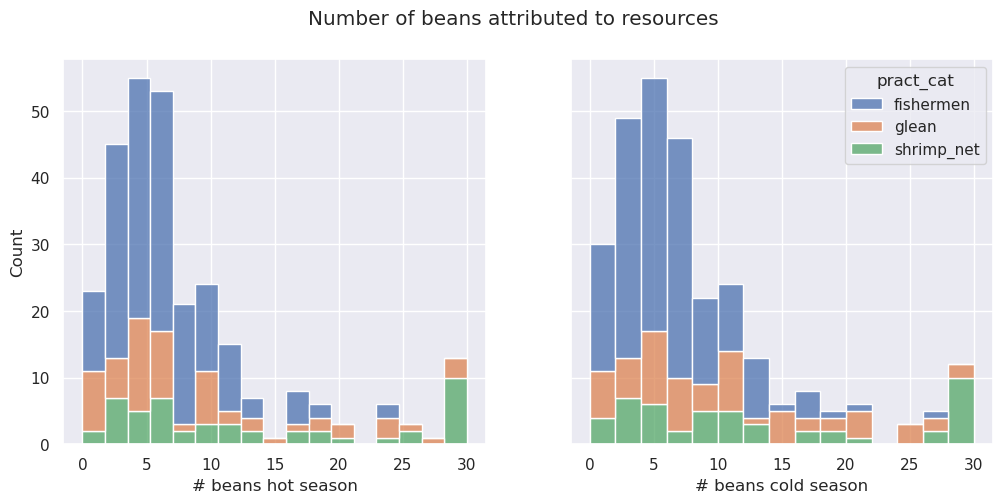

In [2743]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="prop_cap_hot_raw", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("# beans hot season")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="prop_cap_cold_raw", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("# beans cold season")
axes[0].get_legend().remove()
f.suptitle('Number of beans attributed to resources') 
plt.show()

The data is right skewed with an uptick at 30. We can see that shrimp net fishers tend to have a high proportion of their catch come exclusively from one resource. The likely resource is shrimp (prawns). <br>

#### Proportion of Capture from Focal Resources
Lets see how much of fishers' harvest is captured by focusing analysis on focal resources. This can help us understand how well our index represents each gear type

In [2744]:
# sum proportions across gears 
cap_prop_df= df_wk.groupby(['id','pract_cat']).agg(
    count = ('prop_cap_hot', 'size'),
    prop_captured_hot=('adj_prop_cap_hot', np.sum),
    prop_captured_cold=('adj_prop_cap_cold', np.sum))

# drop zeros
cap_prop_df = cap_prop_df[cap_prop_df['count']>0].drop(['count'], axis=1)

# visualize
cap_prop_df.groupby('pract_cat').describe()


prop_captured_hot                                          \
                       count      mean       std       min       25%   
pract_cat                                                              
fishermen               49.0  0.740755  0.244531  0.032258  0.612903   
glean                   31.0  0.852126  0.257717  0.090909  0.750000   
shrimp_net              29.0  0.988506  0.043894  0.800000  1.000000   

                               prop_captured_cold                           \
                 50%  75%  max              count      mean       std  min   
pract_cat                                                                    
fishermen   0.766667  1.0  1.0               49.0  0.691336  0.301453  0.0   
glean       1.000000  1.0  1.0               31.0  0.891637  0.234502  0.0   
shrimp_net  1.000000  1.0  1.0               29.0  0.988506  0.043894  0.8   

                                     
            25%       50%  75%  max  
pract_cat                            
fishermen   0.5  0.766667  1.0  1.0  
glean       0.9  1.000000  1.0  1.0  
shrimp_net  1.0  1.000000  1.0  1.0

A large proportion of fishers' harvest is captured by focusing our analysis on focal resource. The proportion captured is highest for shrimpers and lowest for fishers. This is to be expected, as shrimp netters target very few species, while fishermen use gear that select a larger variety of resources. This implies that we may over estimate fishers reliance on focal resources (their capture and therefore income from non-focal resources will not be included in total monthly income). 

### Days Harvested
Examine how many days per tide (15 days per tide, 2 tides per month) fishers collect resources

In [2745]:
print("hot season n\ " + str(df_wk['days_hot'].describe()))

hot season n\ count    271.000000
mean       5.787316
std        3.886025
min        0.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       15.000000
Name: days_hot, dtype: float64


In [2746]:
print("cold season \n" + str(df_wk['days_cold'].describe()))

cold season 
count    261.000000
mean       5.030722
std        3.905446
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       15.000000
Name: days_cold, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


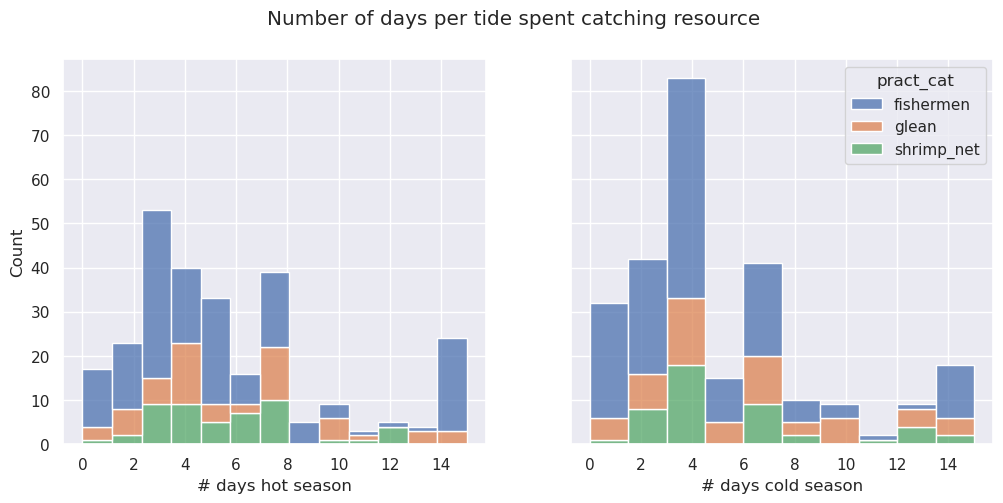

In [2747]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="days_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("# days hot season")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="days_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("# days cold season")
axes[0].get_legend().remove()
f.suptitle('Number of days per tide spent catching resource') 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


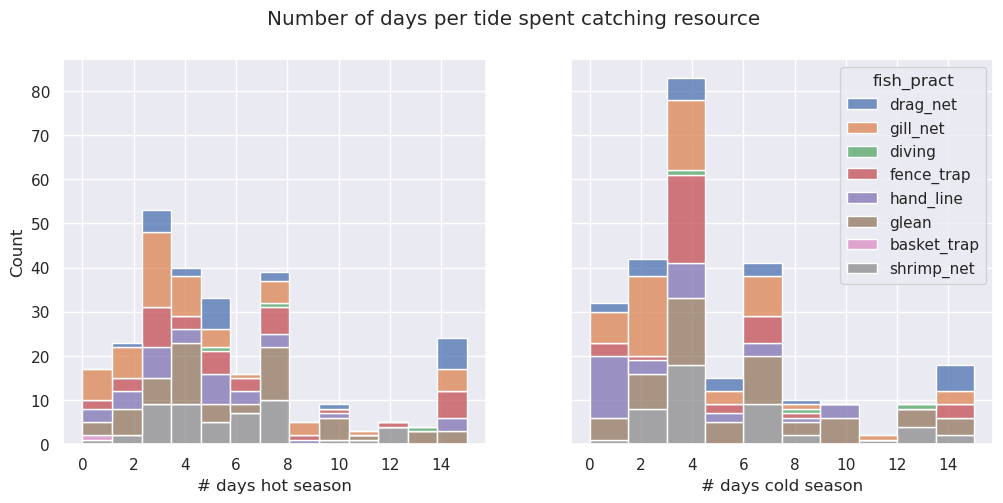

In [2748]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="days_hot", kde=False, hue="fish_pract", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("# days hot season")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="days_cold", kde=False, hue="fish_pract", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("# days cold season")
axes[0].get_legend().remove()
f.suptitle('Number of days per tide spent catching resource') 
plt.show()

The responses are right skewed with an uptick at 15. One possible explaination based on observation in the field, is the fishers who's responses were recorded as `15` responded "every day." Did they really mean every day? Or did they mean every day of the spring tide or every day where there is good weather/no prior obligation? 
We can see that the majority of fishers who responded that they catch a reosurce 15 days a tide are fishermen. Most fishermen have access to boats and can therefore still go out during the neap tide. 



#### Plcce a cap on number of days harvested
Even with this consideration, after extensive observation of fishing in the Bay, the research team believes the uptick at the 15 day mark is not reflective of real fishing patters. For example, in may communtiites, fishing is prohibited on sundays - which would cap the maxiumum at 13 days. On top of that, there is often several days (3-5) within the neap portion of a tidal cycle where most fishers do not fish because there is very little variation in the tide. Finally there is also bad weather and prior obligations that prevent fishers from going out every day. 

Another thing to note from the data is that fishers spend more days targeting resources in the hot season. This was also observed during the data collection period.

Given these considerations, the number of days fished was capped conservatively at 13 days for the hot season and 12 days for the cold season. 

In [2749]:
def cap_days(days, cap):
    if days > cap:
        return cap
    else:
        return days
    
df_wk['days_hot'] = df_wk.apply(lambda row: cap_days(row['days_hot'],13), axis=1)
df_wk['days_cold'] = df_wk.apply(lambda row: cap_days(row['days_hot'],12), axis=1)

Let's examine the data grouped by fishing gear used.

In [2824]:
df_wk.groupby('fish_pract')['days_hot'].describe()

,count,mean,std,min,25%,50%,75%,max
fish_pract,,,,,,,,
drag_net,25.0,7.000000,4.143268,2.0,4.0,5.0,13.0,13.0
gill_net,59.0,4.627119,3.408399,1.0,3.0,3.0,5.5,13.0
diving,3.0,8.666667,4.041452,5.0,6.5,8.0,10.5,13.0
fence_trap,40.0,6.110625,3.808530,1.0,3.0,5.0,8.0,13.0
hand_line,35.0,5.054378,3.267939,1.0,3.0,5.0,6.0,13.0
glean,55.0,6.036991,3.579587,0.0,4.0,5.0,8.0,13.0
basket_trap,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
shrimp_net,49.0,5.653061,2.802908,1.0,4.0,5.0,7.0,12.0


#### Estimate the number of days a fisher fishes per tide
The information above is at the resource level. Some fishers may catch certain resources less than others. To try understand how many days in total fishers fish per tide, we can approximate using the maximum number of days they catch a resource.

In [2751]:
days_max = df_wk.groupby(['id','fish_pract']).agg(max_days_hot=('days_hot', np.max), max_days_cold = ('days_cold', np.max)).reset_index() 
days_max

,id,fish_pract,max_days_hot,max_days_cold
0,01022023MOR04,drag_net,NaN,NaN
1,01022023MOR04,gill_net,NaN,NaN
2,01022023MOR04,diving,NaN,NaN
3,01022023MOR04,fence_trap,NaN,NaN
4,01022023MOR04,hand_line,NaN,NaN
...,...,...,...,...
755,O1O22023MOR06,fence_trap,NaN,NaN
756,O1O22023MOR06,hand_line,NaN,NaN
757,O1O22023MOR06,glean,NaN,NaN
758,O1O22023MOR06,basket_trap,NaN,NaN


In [2752]:
# merge max days information with main df
print("shape of df before merge: " +str(df_wk.shape))
df_wk = pd.merge(df_wk,days_max,on=['id','fish_pract'], how='left')
print("shape of df after merge: " +str(df_wk.shape))

shape of df before merge: (284, 75)
shape of df after merge: (284, 77)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


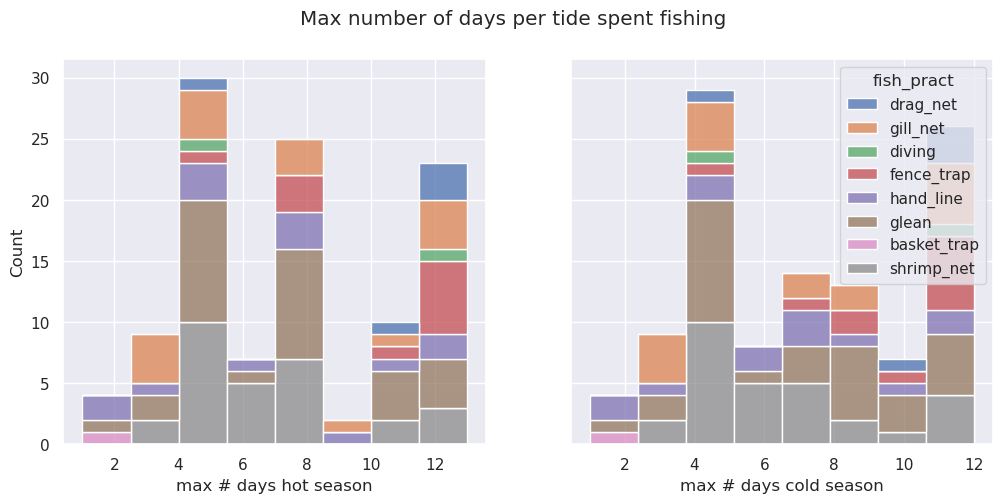

In [2753]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=days_max, stat="count",multiple="stack", x="max_days_hot", kde=False, hue="fish_pract", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("max # days hot season")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=days_max, stat="count",multiple="stack", x="max_days_cold", kde=False, hue="fish_pract", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("max # days cold season")
axes[0].get_legend().remove()
f.suptitle('Max number of days per tide spent fishing') 
plt.show()

In [2754]:

days_max.groupby('fish_pract')['max_days_hot'].describe()

,count,mean,std,min,25%,50%,75%,max
fish_pract,,,,,,,,
drag_net,5.0,10.800000,3.492850,5.0,10.0,13.0,13.0,13.0
gill_net,17.0,7.294118,3.980652,3.0,4.0,7.0,11.0,13.0
diving,2.0,9.000000,5.656854,5.0,7.0,9.0,11.0,13.0
fence_trap,11.0,10.363636,3.170890,4.0,8.0,12.0,13.0,13.0
hand_line,14.0,6.658986,3.642903,1.0,5.0,6.5,8.5,13.0
glean,31.0,7.032258,3.351456,1.0,4.0,7.0,9.0,13.0
basket_trap,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
shrimp_net,29.0,6.448276,2.706951,3.0,4.0,6.0,7.0,12.0


In [2755]:
days_max.groupby('fish_pract').agg(Median=('max_days_hot', np.median))

,Median
fish_pract,
drag_net,13.0
gill_net,7.0
diving,9.0
fence_trap,12.0
hand_line,6.5
glean,7.0
basket_trap,1.0
shrimp_net,6.0


### Daily Capture Quantity

We need to calculate daily capture of focal resources <br>
`Capture is calculated as follows: (qantity captured)(# of units)(kilograms/unit)` <br>
<n></n>
Units are converted to kilograms using the unit conversion sheet, developed in using estimates provided by local researchers in the "units match sheet"

In [2756]:
# read unit match sheet
units_cnv_path ="/home/rthoms/ocean_dep/sur_B/clean_up/units.csv"
units_cnv = pd.read_csv(units_cnv_path)


Create two dictionaries for conversions. Create a dictionary to link the units with their conversions to kilograms. Create a second dictionary to link gears (practices) to the average number of persons using a gear (from Survey C)

In [2757]:
# create a dictionary of units and their conversions to kgs
unit_dict= pd.Series(units_cnv.weight_kg.values,index=units_cnv.unit).to_dict()

# read practice summary table
gear_cnv_path ="/home/rthoms/ocean_dep/sur_C/initial_analysis/practice_summary/practice_summary.csv"
gear_cnv = pd.read_csv(gear_cnv_path).fillna(1)

# create a dictionary of units and their conversions to kgs
gear_dict= pd.Series(gear_cnv.persons.values,index=gear_cnv.gear).to_dict()

In [2758]:
#function to calculate daily capture
def cap_quant(units, quant):
    units_cv = float(unit_dict[units])
    if units_cv is not None:
        cap_p_mo = (quant* units_cv)
    else: 
        cap_p_mo = None
    return cap_p_mo

#apply function to df
df_wk['cap_daily_hot'] = df_wk.apply(lambda row: cap_quant(row['cap_units_hot'], row['quant_cap_hot']), axis=1)
df_wk['cap_daily_cold'] = df_wk.apply(lambda row: cap_quant(row['cap_units_cold'], row['quant_cap_cold']), axis=1)


In [2759]:
print("daily capture during the hot season \n" + str(df_wk['cap_daily_hot'].describe()))

daily capture during the hot season 
count    262.000000
mean       9.257061
std       15.738388
min        0.250000
25%        1.781250
50%        4.000000
75%       12.000000
max      125.000000
Name: cap_daily_hot, dtype: float64


In [2760]:
print("daily capture during the hot season by gear type \n" + str(df_wk.groupby('fish_pract')['cap_daily_hot'].describe()))

daily capture during the hot season by gear type 
             count       mean        std     min     25%     50%     75%  \
fish_pract                                                                 
drag_net      25.0  33.260000  36.367087   2.000  10.000  15.000  50.000   
gill_net      55.0  12.791364  12.588745   0.500   4.500  10.000  13.750   
diving         2.0  11.000000   1.414214  10.000  10.500  11.000  11.500   
fence_trap    39.0   9.488462   8.255616   1.000   3.000   7.500  12.000   
hand_line     34.0   3.360294   1.985927   0.250   2.000   3.000   4.000   
glean         57.0   2.624781   2.892160   0.250   0.875   1.500   3.000   
basket_trap    1.0   0.625000        NaN   0.625   0.625   0.625   0.625   
shrimp_net    49.0   4.771173   5.224848   0.250   1.050   2.625   5.250   

                 max  
fish_pract            
drag_net     125.000  
gill_net      60.000  
diving        12.000  
fence_trap    36.000  
hand_line      8.000  
glean         12.000  
baske

In [2761]:
print("daily capture during the cold season \n" + str(df_wk['cap_daily_cold'].describe()))

daily capture during the cold season 
count    249.000000
mean       6.422691
std       10.315155
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       75.000000
Name: cap_daily_cold, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


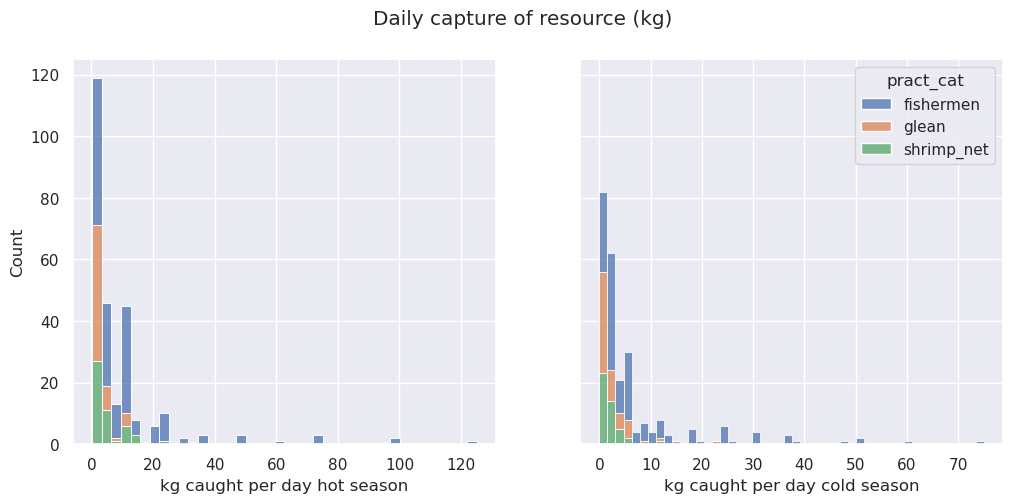

In [2762]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="cap_daily_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("kg caught per day hot season")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="cap_daily_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("kg caught per day cold season")
axes[0].get_legend().remove()
f.suptitle('Daily capture of resource (kg)') 
plt.show()

The data is right skewed. There are some outliers. Let's look at them.

In [2763]:
outliers = df_wk[df_wk['cap_daily_hot']>(df_wk['cap_daily_hot'].mean()+3*df_wk['cap_daily_hot'].std())]
outliers[['id','fish_pract', 'days_hot','focal_resource', 'quant_cap_hot', 'cap_units_hot','cap_daily_hot']]

,id,fish_pract,days_hot,focal_resource,quant_cap_hot,cap_units_hot,cap_daily_hot
3,01022023MORB07,drag_net,13.0,56,3.0,Caixas,75.0
5,01022023MORB07,drag_net,13.0,50,4.0,Caixas,100.0
6,01022023MORB07,drag_net,7.0,10,3.0,Caixas,75.0
10,O1O22023MOR06,drag_net,13.0,50,3.0,caixas,75.0
11,O1O22023MOR06,drag_net,5.0,10,5.0,Caixas,125.0
13,24012023CUGB01,drag_net,13.0,50,4.0,Caixas,100.0
85,16022023NHMUB06,gill_net,13.0,03,5.0,basin,60.0


Almost all of these outliers are from drag nets, where 10-15 fishers use a singular large net. The majority are from Morrumbene, where the nets are especially large, and have access to areas closer to the opening of the bay. We consulted other data collected from the area [(Santana Afonso and Mafuca, 2001) & (Santos, 2004)] where average CPUE for drag nets was found to be 50.98 kg/net/day and 32.6 kg/net/day for total capture. 

#### Total Daily Capture per Fisher
Since the above information is at a resource level. Lets look at the total capture per fishing unit to compare with the existing literature

In [2764]:
cap_daily_total_hot = (df_wk.groupby(['id','fish_pract'])['cap_daily_hot']
        .agg([('Count','size'), ('cap_daily_total_hot','sum')])
        .reset_index())
cap_daily_total_hot =  cap_daily_total_hot[cap_daily_total_hot['Count']>0]   
cap_daily_total_hot.groupby('fish_pract')['cap_daily_total_hot'].describe()

,count,mean,std,min,25%,50%,75%,max
fish_pract,,,,,,,,
drag_net,5.0,166.300000,95.686728,35.0000,106.000,192.000,223.5000,275.000
gill_net,17.0,41.383824,29.896197,7.0000,19.000,36.000,57.0000,108.000
diving,2.0,11.000000,1.414214,10.0000,10.500,11.000,11.5000,12.000
fence_trap,11.0,33.640909,30.791531,5.0000,11.000,25.000,41.0250,108.000
hand_line,14.0,8.160714,4.939643,3.0000,4.250,6.500,11.2500,18.000
glean,31.0,4.826210,3.674839,0.7875,2.000,4.000,5.6125,13.750
basket_trap,1.0,0.625000,NaN,0.6250,0.625,0.625,0.6250,0.625
shrimp_net,29.0,8.061638,7.893226,1.0500,3.500,5.200,12.0000,38.250


In [2765]:
cap_daily_total_cold = (df_wk.groupby(['id','fish_pract'])['cap_daily_cold']
        .agg([('Count','size'), ('cap_daily_total_cold','sum')])
        .reset_index())
cap_daily_total_cold =  cap_daily_total_cold[cap_daily_total_cold['Count']>0]   
cap_daily_total_cold.groupby('fish_pract')['cap_daily_total_cold'].describe()

,count,mean,std,min,25%,50%,75%,max
fish_pract,,,,,,,,
drag_net,5.0,77.900000,36.734521,38.5,61.50000,70.000,82.5000,137.00
gill_net,17.0,32.747059,29.834860,2.0,9.00000,19.500,59.5000,96.00
diving,2.0,13.375000,10.429825,6.0,9.68750,13.375,17.0625,20.75
fence_trap,11.0,26.590909,40.634848,4.0,5.75000,16.000,23.2500,144.00
hand_line,14.0,5.801786,4.051833,2.0,2.79375,4.000,9.2500,14.00
glean,31.0,5.084274,5.583232,0.0,1.60000,3.750,6.2500,27.50
basket_trap,1.0,0.000000,NaN,0.0,0.00000,0.000,0.0000,0.00
shrimp_net,29.0,3.274569,2.465812,0.7,1.75000,2.875,4.0625,13.00


These values are significantly higher than those recorded in previous literature.

We can also compare these responses to those captured in Survey C. In survey C, fishers were asked to provide their average daily capture. See the cleaned responses below.

In [2766]:
sur_c = pd.read_csv("/home/rthoms/ocean_dep/sur_C/clean_up/adaptive_cap_clean.csv")
gear_sum = sur_c.groupby(['gear'])['cap_daily_total'].describe()
gear_sum

,count,mean,std,min,25%,50%,75%,max
gear,,,,,,,,
basket_trap,2.0,3.500000,0.707107,3.00,3.25,3.5,3.7500,4.0
diving,1.0,6.000000,NaN,6.00,6.00,6.0,6.0000,6.0
drag_net,4.0,57.500000,29.860788,30.00,45.00,50.0,62.5000,100.0
fence_trap,13.0,4.884615,2.399252,3.00,4.00,4.0,5.0000,12.0
gill_net,14.0,10.964286,6.252582,3.00,6.25,10.0,12.3750,24.0
glean,23.0,3.928261,3.729400,0.35,2.00,2.5,4.0000,12.0
hand_line,12.0,4.416667,2.429303,2.00,3.00,3.5,5.5000,10.0
shrimp_net,23.0,2.357609,1.205820,1.00,1.75,2.0,2.7125,6.0


In [2767]:
sur_c.groupby('gear').agg(Median=('cap_daily_total', np.median))

,Median
gear,
basket_trap,3.5
diving,6.0
drag_net,50.0
fence_trap,4.0
gill_net,10.0
glean,2.5
hand_line,3.5
shrimp_net,2.0


The average capture totals from survey C are much lower that the aggregated capture totals from survey B. They also present much lower variation (lower standard deviations). They are much closer to averages calcualted from the area: drag net- 32.6, gill net - 18.3, gamboa 5.3, shrimp net 3.3 (Santos, 2004). Catches in the area have been reported to have decreased 68% between 2012 and 2017 (IDEPA, 2017) which may explain why these averages are lower than those reported in the 2004 study.

It is possible that asking for the capture quantities of individual species lead to an over-estimation of total capture. Based on the large difference and suspected inaccuracies in the Survey B capture quantities, we have decided to only report capture at the fisher level (not resource level) using results from survey C.


#### Estimate Daily Capture Quantities from Survey C 
To provide a comparison of capture calculations we have decided to also estimate daily capture totals by combining average gear-specific capture totals from Survey C with catch porportions from Survey B. The estimate is calculated as follows: <br>
`(estimated daily capture quantity for resource y caught using gear x) = (mean gear-specific capture quantity for gear x)(adjusted gear-specific capture proportion for resource y)` <br>
These estimations are just for exploration and will help triangulate survey B responses

In [2768]:
#function to append max total daily capture for gear type from survey C
def cap_tot_av(gear):
    av_daily_cap = gear_sum['mean'][gear]
    return av_daily_cap

def estimate(gear, prop):
    av_daily_cap = gear_sum['mean'][gear]
    est_daily_cap = av_daily_cap * prop
    return est_daily_cap

#apply functions to df
df_wk['av_cap_daily'] = df_wk.apply(lambda row: cap_tot_av(row['fish_pract']), axis=1)
df_wk['est_cap_daily_hot'] = df_wk.apply(lambda row: estimate(row['fish_pract'], row['adj_prop_cap_hot']), axis=1)
df_wk['est_cap_daily_cold'] = df_wk.apply(lambda row: estimate(row['fish_pract'], row['adj_prop_cap_cold']), axis=1)

# check data
df_wk[['id','focal_resource', 'av_cap_daily','cap_daily_hot', 'est_cap_daily_hot', 'cap_daily_hot', 'est_cap_daily_cold']]

,id,focal_resource,av_cap_daily,cap_daily_hot,est_cap_daily_hot,cap_daily_hot,est_cap_daily_cold
0,O1O22023MOR06,01,57.500000,5.00,3.833333,5.00,5.750000
1,24012023CUGB01,53,57.500000,2.00,4.259259,2.00,4.423077
2,24012023CUGB01,01,57.500000,25.00,6.388889,25.00,13.269231
3,01022023MORB07,56,57.500000,75.00,15.333333,75.00,1.916667
4,01022023MORB07,54,57.500000,10.00,5.750000,10.00,9.583333
...,...,...,...,...,...,...,...
279,02022023MARB09,56,2.357609,4.20,1.886087,4.20,2.043261
280,1902023ILHB06,56,2.357609,24.00,2.357609,24.00,2.357609
281,31012023MUCB07,56,2.357609,1.05,2.357609,1.05,2.357609
282,31012023MUCB08,56,2.357609,10.50,2.357609,10.50,2.357609


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


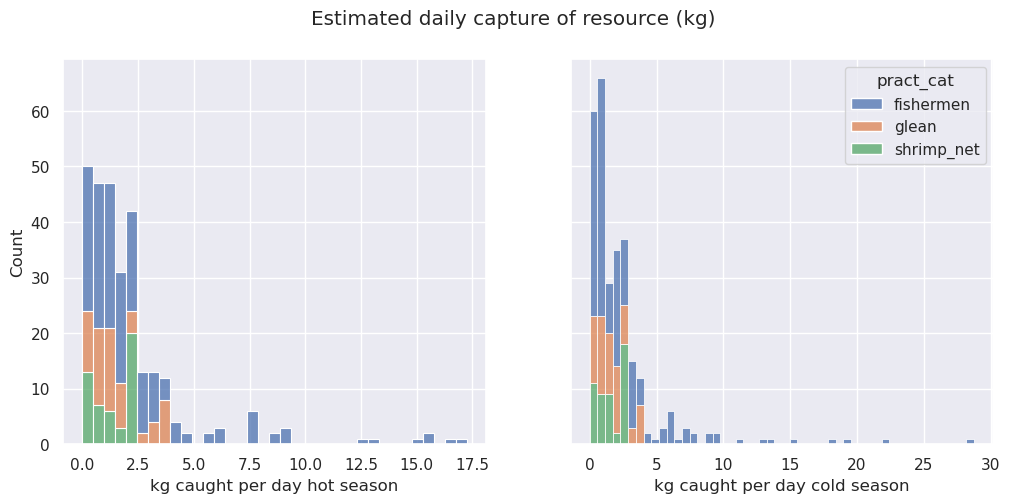

In [2769]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="est_cap_daily_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("kg caught per day hot season")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="est_cap_daily_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("kg caught per day cold season")
axes[0].get_legend().remove()
f.suptitle('Estimated daily capture of resource (kg)') 
plt.show()

### Monthly Capture 

Next lets calculate the quantity of resource captured per month. This value is estimated by scaling up daily captures using the number of days per tide that resource is caught. There are two tides per month. The formula is as follows: <br>

`(monthly capture) = 2(days per tide)(daily capture) `

In [2770]:
# function to calculate monthly capture
def monthly_cap(days, daily_cap):
    return 2*days*daily_cap

# apply function to df
df_wk['cap_monthly_hot'] = df_wk.apply(lambda row: monthly_cap(row['days_hot'], row['cap_daily_hot']), axis=1)
df_wk['cap_monthly_cold'] = df_wk.apply(lambda row: monthly_cap(row['days_cold'], row['cap_daily_cold']), axis=1)

# apply function to estimated capture
df_wk['est_cap_monthly_hot'] = df_wk.apply(lambda row: monthly_cap(row['days_hot'], row['est_cap_daily_hot']), axis=1)
df_wk['est_cap_monthly_cold'] = df_wk.apply(lambda row: monthly_cap(row['days_cold'], row['est_cap_daily_cold']), axis=1)

In [2771]:
df_wk['cap_monthly_hot'].describe()

count     262.000000
mean      132.401219
std       334.563463
min         1.000000
25%        12.000000
50%        40.000000
75%       100.000000
max      2600.000000
Name: cap_monthly_hot, dtype: float64

In [2772]:
df_wk['cap_monthly_cold'].describe()

count     238.000000
mean       68.673597
std       126.380991
min         0.000000
25%        10.675000
50%        24.500000
75%        72.000000
max      1200.000000
Name: cap_monthly_cold, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


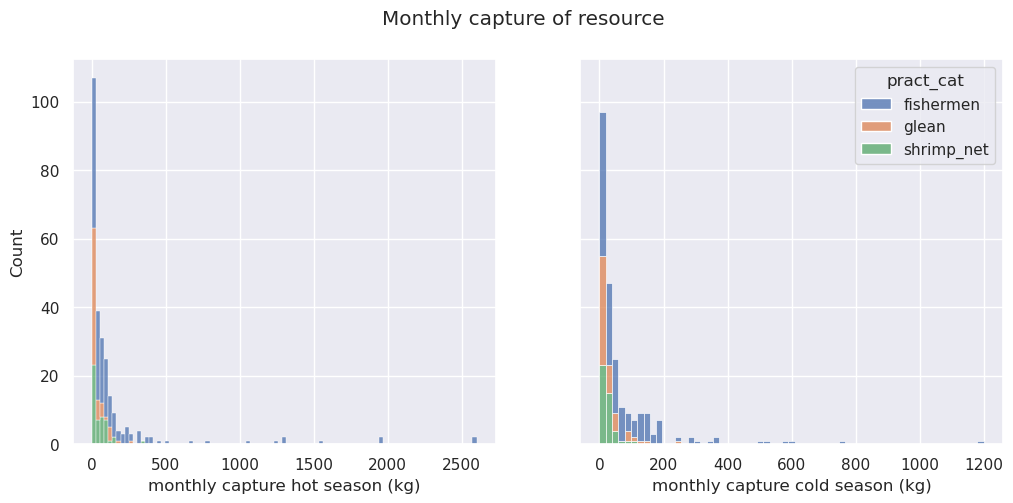

In [2773]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="cap_monthly_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("monthly capture hot season (kg)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="cap_monthly_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("monthly capture cold season (kg)")
axes[0].get_legend().remove()
f.suptitle('Monthly capture of resource') 
plt.show()

Examine the outliers

In [2774]:
outliers= df_wk[df_wk['cap_monthly_hot']>(df_wk['cap_monthly_hot'].mean()+3*df_wk['cap_monthly_hot'].std())]
outliers[['id','fish_pract','days_hot','quant_cap_hot', 'cap_units_hot','cap_daily_hot','cap_monthly_hot']]

,id,fish_pract,days_hot,quant_cap_hot,cap_units_hot,cap_daily_hot,cap_monthly_hot
3,01022023MORB07,drag_net,13.0,3.0,Caixas,75.0,1950.0
5,01022023MORB07,drag_net,13.0,4.0,Caixas,100.0,2600.0
10,O1O22023MOR06,drag_net,13.0,3.0,caixas,75.0,1950.0
11,O1O22023MOR06,drag_net,5.0,5.0,Caixas,125.0,1250.0
12,24012023CUGB01,drag_net,13.0,2.0,caixas,50.0,1300.0
13,24012023CUGB01,drag_net,13.0,4.0,Caixas,100.0,2600.0
44,24012023CUGB02,gill_net,13.0,50.0,kgs,50.0,1300.0
85,16022023NHMUB06,gill_net,13.0,5.0,basin,60.0,1560.0


In [2775]:
outliers= df_wk[df_wk['cap_monthly_cold']>(df_wk['cap_monthly_cold'].mean()+3*df_wk['cap_monthly_cold'].std())]
outliers[['id','fish_pract','days_cold','quant_cap_cold', 'cap_units_cold','cap_daily_cold','cap_monthly_cold']]

,id,fish_pract,days_cold,quant_cap_cold,cap_units_cold,cap_daily_cold,cap_monthly_cold
2,24012023CUGB01,drag_net,5.0,2.0,caixas,50.0,500.0
5,01022023MORB07,drag_net,12.0,1.0,Caixa,25.0,600.0
6,01022023MORB07,drag_net,7.0,1.5,Caixas,37.5,525.0
10,O1O22023MOR06,drag_net,12.0,2.0,caixas,50.0,1200.0
11,O1O22023MOR06,drag_net,5.0,3.0,caixas,75.0,750.0
85,16022023NHMUB06,gill_net,12.0,2.0,basin,24.0,576.0


The highest captures are drag nets which are used by groups of 10+

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


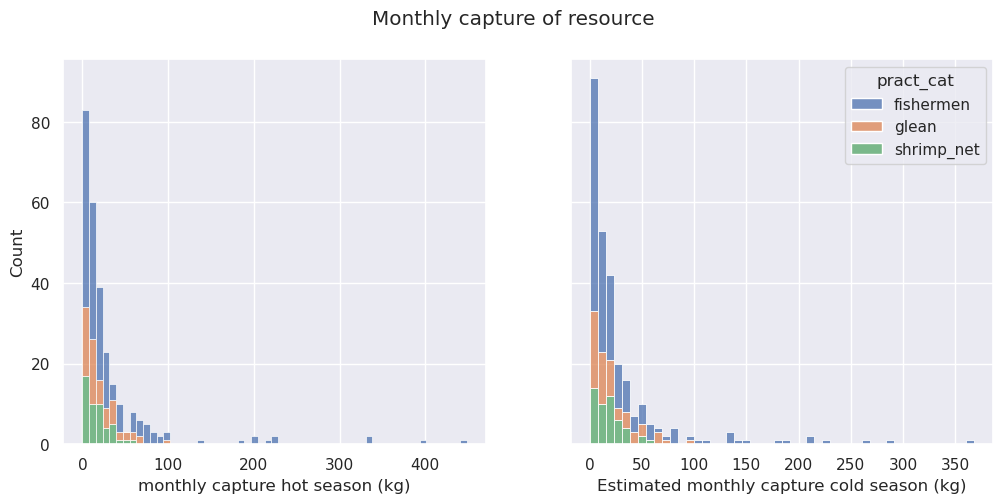

In [2776]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="est_cap_monthly_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("monthly capture hot season (kg)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="est_cap_monthly_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("Estimated monthly capture cold season (kg)")
axes[0].get_legend().remove()
f.suptitle('Monthly capture of resource') 
plt.show()

### Resource Use
Respondents were asked to identify what proportion of their catch of a given resource is normally sold, eaten, traded, or offered

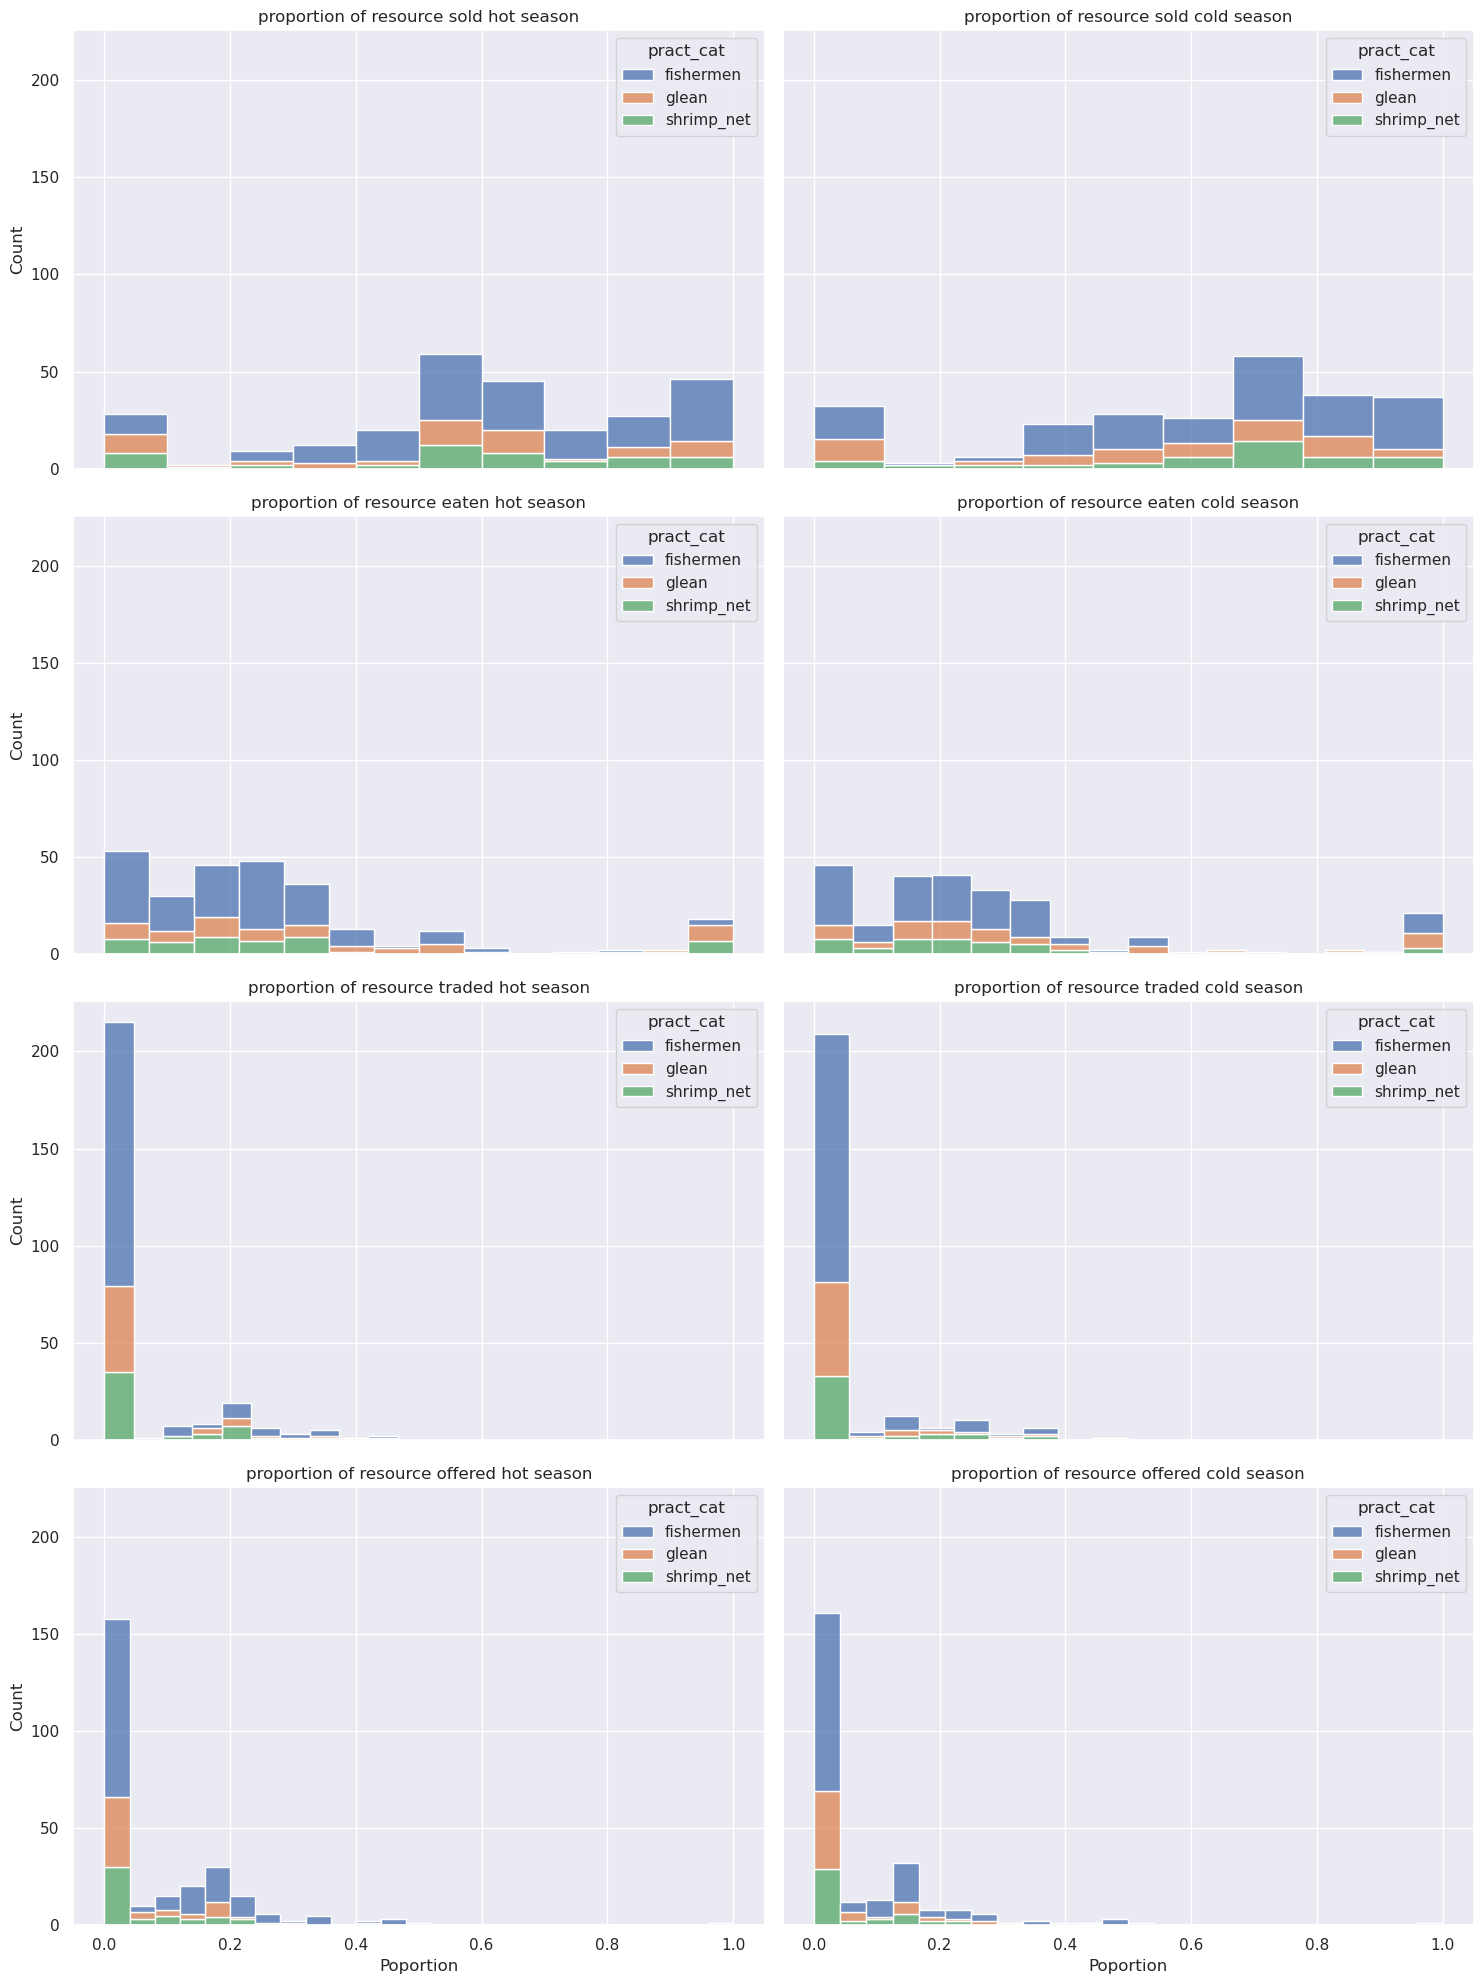

In [2777]:
f, axes = plt.subplots(4, 2, sharey=True, sharex = True, figsize=(15,20))
axe = axes.ravel()
sns.histplot(data=df_wk, stat="count",multiple="stack", x="sold_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axe[0])
axe[0].set_title("proportion of resource sold hot season")
sns.histplot(data=df_wk, stat="count",multiple="stack", x="sold_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axe[1])
axe[1].set_title("proportion of resource sold cold season")
sns.histplot(data=df_wk, stat="count",multiple="stack", x="eaten_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axe[2])
axe[2].set_title("proportion of resource eaten hot season")
sns.histplot(data=df_wk, stat="count",multiple="stack", x="eaten_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axe[3])
axe[3].set_title("proportion of resource eaten cold season")
sns.histplot(data=df_wk, stat="count",multiple="stack", x="traded_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axe[4])
axe[4].set_title("proportion of resource traded hot season")
sns.histplot(data=df_wk, stat="count",multiple="stack", x="traded_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axe[5])
axe[5].set_title("proportion of resource traded cold season")
sns.histplot(data=df_wk, stat="count",multiple="stack", x="offered_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axe[6])
axe[6].set_title("proportion of resource offered hot season")
axe[6].set_xlabel("Poportion")
sns.histplot(data=df_wk, stat="count",multiple="stack", x="offered_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axe[7])
axe[7].set_title("proportion of resource offered cold season")
axe[7].set_xlabel("Poportion")

plt.tight_layout()

### Sale Income

Calculate the income earned per species per month <br>

The formula is as follows: <br>

`(sale income) = (monthy catch)(proportion of catch sold)(proportion of catch for each crew member) (price per kg)`

In [2778]:
# function to calculate income per month
def income(monthly_cap,catch_prop,sell_prop,price,sale_unit):
    units_sale_cv = float(unit_dict[sale_unit])
    price_per_kg = (price/units_sale_cv)
    income = monthly_cap*catch_prop*sell_prop* price_per_kg
    return income

# apply to df
df_wk['cap_income_hot'] = df_wk.apply(lambda row: income(row['cap_monthly_hot'], row['catch_proportion'],  row['sold_hot'], row['sale_price_hot'], row['sale_unit_hot']), axis=1)
df_wk['cap_income_cold'] = df_wk.apply(lambda row: income(row['cap_monthly_cold'], row['catch_proportion'],  row['sold_cold'], row['sale_price_cold'], row['sale_unit_cold']), axis=1)

# apply to estimated columns
df_wk['est_cap_income_hot'] = df_wk.apply(lambda row: income(row['est_cap_monthly_hot'], row['catch_proportion'],  row['sold_hot'], row['sale_price_hot'], row['sale_unit_hot']), axis=1)
df_wk['est_cap_income_cold'] = df_wk.apply(lambda row: income(row['est_cap_monthly_cold'], row['catch_proportion'],  row['sold_cold'], row['sale_price_cold'], row['sale_unit_cold']), axis=1)

In [2779]:
df_wk['cap_income_hot'].describe()

count       238.000000
mean       7167.061333
std       22168.088816
min          33.333333
25%         745.967742
50%        2160.000000
75%        5485.714286
max      236600.000000
Name: cap_income_hot, dtype: float64

In [2780]:
df_wk['cap_income_cold'].describe()

count       208.000000
mean       4927.479220
std       14948.106038
min           0.000000
25%         658.333333
50%        2000.000000
75%        5040.000000
max      188160.000000
Name: cap_income_cold, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


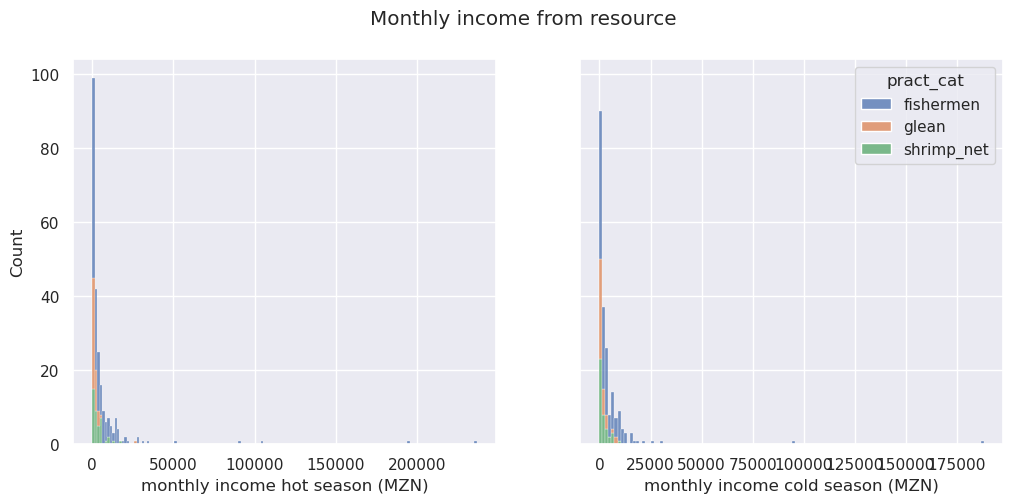

In [2781]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="cap_income_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("monthly income hot season (MZN)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="cap_income_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("monthly income cold season (MZN)")
axes[0].get_legend().remove()
f.suptitle('Monthly income from resource') 
plt.show()

In [2782]:
outliers = df_wk[df_wk['cap_income_hot']>(df_wk['cap_income_hot'].mean()+3*df_wk['cap_income_hot'].std())]
outliers[['id','focal_resource','fish_pract','owner','days_hot','cap_units_hot','quant_cap_hot','catch_proportion','sold_hot','sale_price_hot','sale_unit_hot','cap_monthly_hot','cap_income_hot']]

,id,focal_resource,fish_pract,owner,days_hot,cap_units_hot,quant_cap_hot,catch_proportion,sold_hot,sale_price_hot,sale_unit_hot,cap_monthly_hot,cap_income_hot
12,24012023CUGB01,56,drag_net,owner,13.0,caixas,2.0,0.3,0.900000,300.0,kgs,1300.0,105300.0
36,08022023MADB05,56,gill_net,owner,13.0,kgs,20.0,1.0,0.700000,250.0,kgs,520.0,91000.0
43,24012023CUGB02,53,gill_net,owner,13.0,kgs,15.0,1.0,0.866667,700.0,kgs,390.0,236600.0
44,24012023CUGB02,56,gill_net,owner,13.0,kgs,50.0,1.0,0.600000,250.0,kgs,1300.0,195000.0


In [2783]:
outliers = df_wk[df_wk['cap_income_cold']>(df_wk['cap_income_cold'].mean()+3*df_wk['cap_income_cold'].std())]
outliers[['id','focal_resource','fish_pract', 'owner', 'days_cold','cap_units_cold','quant_cap_cold','catch_proportion','sold_cold','sale_price_cold','sale_unit_cold','cap_monthly_cold','cap_income_cold']]


,id,focal_resource,fish_pract,owner,days_cold,cap_units_cold,quant_cap_cold,catch_proportion,sold_cold,sale_price_cold,sale_unit_cold,cap_monthly_cold,cap_income_cold
43,24012023CUGB02,53,gill_net,owner,12.0,kgs,10.5,1.0,0.933333,800.0,kgs,252.0,188160.0
44,24012023CUGB02,56,gill_net,owner,12.0,kgs,12.5,1.0,0.700000,450.0,kgs,300.0,94500.0


These outliers are drag and gill nets where the respondent takes a large or all of the proceeds from the catch. This is possible since the drag net respondents are either the owner or the crew supervisors. Similarly, the gill_net respondents are the owners and their crew may consist entirely of their family, meaning all proceeds stay within the family.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


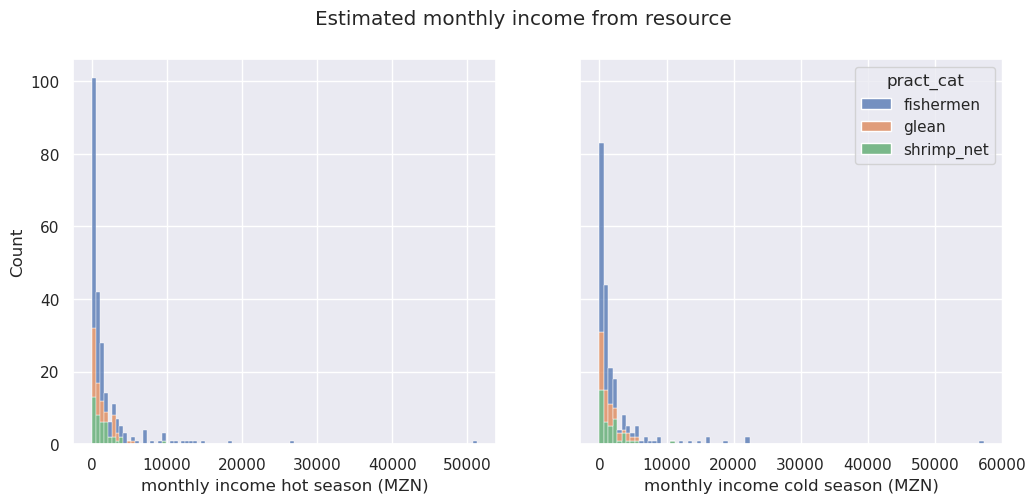

In [2784]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="est_cap_income_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("monthly income hot season (MZN)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="est_cap_income_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("monthly income cold season (MZN)")
axes[0].get_legend().remove()
f.suptitle('Estimated monthly income from resource') 
plt.show()

#### Calculate total monthly income per fisher

In [2785]:
mo_income_tot = (df_wk.groupby(['id','fish_pract'])['cap_income_hot']
        .agg([('Count','size'), ('total','sum')])
        .reset_index())
mo_income_tot =  mo_income_tot[mo_income_tot['Count']>0]   
mo_income_tot.groupby('fish_pract')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
fish_pract,,,,,,,,
drag_net,5.0,62993.453333,57106.615458,12993.600000,39468.000000,41976.666667,59864.000000,160665.000000
gill_net,17.0,43733.337582,104098.368579,2446.400000,3588.000000,10752.000000,26283.333333,434520.000000
diving,2.0,8350.000000,4737.615434,5000.000000,6675.000000,8350.000000,10025.000000,11700.000000
fence_trap,11.0,28179.311688,17887.529043,8424.000000,14656.880952,27600.000000,29300.000000,71322.666667
hand_line,14.0,6431.949749,5074.058828,133.333333,3180.000000,4345.000000,10411.904762,15646.666667
glean,31.0,2923.179724,5612.668354,0.000000,522.500000,1600.000000,3188.000000,31748.571429
basket_trap,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
shrimp_net,29.0,4827.182594,3952.977962,420.000000,2281.666667,4200.000000,5485.714286,18000.000000


In [2786]:
mo_income_tot = (df_wk.groupby(['id','fish_pract'])['est_cap_income_hot']
        .agg([('Count','size'), ('total','sum')])
        .reset_index())
mo_income_tot =  mo_income_tot[mo_income_tot['Count']>0]   
mo_income_tot.groupby('fish_pract')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
fish_pract,,,,,,,,
drag_net,5.0,26186.697957,14246.110413,8649.916667,22661.809211,23263.247778,28288.516129,48070.000000
gill_net,17.0,8284.394771,16149.697776,385.942857,1476.231429,2385.828571,4171.910714,64691.992945
diving,2.0,3547.047619,2305.706855,1916.666667,2731.857143,3547.047619,4362.238095,5177.428571
fence_trap,11.0,6729.359411,6549.484689,1100.876758,1693.338502,3145.692308,12769.780220,17742.008547
hand_line,14.0,2090.987072,1513.295574,47.111111,942.222222,1685.813174,3464.875000,4435.663082
glean,31.0,1931.631907,1963.020859,0.000000,726.728261,1309.420290,2671.217391,7697.894824
basket_trap,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
shrimp_net,29.0,1993.520101,1728.596722,157.173913,1077.763975,1415.163975,2200.434783,9430.434783


#### Remove subsistence records
If a respondent makes no monthly income from a given practice (ie only eats or offers capture), then this practice is defined as subsistence, and should not be included in the analysis of income or it will skew results

In [2787]:
mo_income_tot[mo_income_tot['total']==0]

,id,fish_pract,Count,total
29,01022023MORB03,glean,3,0.0
69,02022023MARB04,glean,1,0.0
102,02022023MARB08,basket_trap,1,0.0


After reviewing data sheets, `01022023MORB03` and `02022023MARB04` perform other activities for income (shrimp net & gill net). They do not sell their gleaning capture, so these records represent a subsistence practice which should be excluded from the dataframe. The majority of the catch of `02022023MARB08` are not focal resources. The one focal resource logged is `50` (crabs) but they make up a small portion of total capture and are only consumed (not sold). This represents real data that should be included in the dataset and highlights that the catch from basket_traps are not well reflected in the focal resources. This, however, makes sense, as basket_traps are a very small portion of all fishers.

In [2788]:
df_wk = df_wk.drop(df_wk[(df_wk['id'] == '01022023MORB03') & (df_wk['fish_pract'] == 'glean')].index)
df_wk = df_wk.drop(df_wk[(df_wk['id'] == '02022023MARB04') & (df_wk['fish_pract'] == 'glean')].index)

#### Estimate monthly income from Survey C responses

In [2789]:
sur_c['persons']  = sur_c['persons'].fillna(1.0)
sur_c = sur_c.dropna(subset=('value'))
sur_c['persons'] = sur_c['persons'].astype(float)
sur_c['value_pp'] = sur_c['value']/sur_c['persons']
gear_inc_sum = sur_c.groupby('gear')['value_pp'].describe()

In [2790]:
def mo_income_total(gear,max_days):
    daily_inc = gear_inc_sum['mean'][gear]
    return daily_inc*max_days

df_wk['estimated_mo_cap_val_hot'] = df_wk.apply(lambda row: mo_income_total(row['fish_pract'], row['max_days_hot']), axis=1)
df_wk['estimated_mo_cap_val_cold'] = df_wk.apply(lambda row: mo_income_total(row['fish_pract'], row['max_days_cold']), axis=1)

In [2791]:
mo_income_tot = (df_wk.groupby(['id','fish_pract'])['estimated_mo_cap_val_hot']
        .agg([('Count','size'), ('total','sum')])
        .reset_index())
mo_income_tot =  mo_income_tot[mo_income_tot['Count']>0]   
mo_income_tot.groupby('fish_pract')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
fish_pract,,,,,,,,
drag_net,5.0,26325.000000,8513.821483,12187.500000,24375.000000,31687.500000,31687.500000,31687.500000
gill_net,17.0,16650.094538,12154.220243,5241.696429,6988.928571,12230.625000,30285.357143,37856.696429
diving,2.0,4650.000000,4454.772721,1500.000000,3075.000000,4650.000000,6225.000000,7800.000000
fence_trap,11.0,19400.349650,9320.945024,6750.000000,13500.000000,18692.307692,23105.769231,40500.000000
hand_line,14.0,8326.998157,6218.667375,936.733333,5152.033333,6791.316667,9133.150000,24355.066667
glean,29.0,3276.671664,2425.912938,810.434783,1620.869565,2633.913043,4052.173913,10535.652174
basket_trap,1.0,550.000000,NaN,550.000000,550.000000,550.000000,550.000000,550.000000
shrimp_net,29.0,1629.484633,1260.347217,433.532609,722.554348,1156.086957,1734.130435,5057.880435


### Trade Income
Some fishing resources are traded for goods. The value of these trades needs to be calculated for inclusion as income. The exchange value of resources was calculated as followed: <br>

(`trade value) = (montly capture)(proportion of capture traded)(value of traded product) / (kilograms of product traded)`

In [2792]:
# function to calculate trade value
def trade_val(montly_cap_tot, catch_prop, trade_prop, quant_traded, trade_unit,value):
    if trade_prop > 0:
        units_trade_cv = float(unit_dict[trade_unit])
        val= montly_cap_tot*trade_prop*catch_prop*(value/(quant_traded*units_trade_cv))
    else:
        val = None
    return val

# apply to dataset
df_wk['val_trade_hot'] = df_wk.apply(lambda row: trade_val(row['cap_monthly_hot'], row['catch_proportion'], row['traded_hot'], row['quant_traded'],  row['unit_traded'], row[' value_product_recieved']), axis=1)
df_wk['val_trade_cold'] = df_wk.apply(lambda row: trade_val(row['cap_monthly_cold'],row['catch_proportion'], row['traded_cold'], row['quant_traded'],  row['unit_traded'], row[' value_product_recieved']), axis=1)

# apply to estimates
df_wk['est_val_trade_hot'] = df_wk.apply(lambda row: trade_val(row['est_cap_monthly_hot'],row['catch_proportion'], row['traded_hot'], row['quant_traded'],  row['unit_traded'], row[' value_product_recieved']), axis=1)
df_wk['est_val_trade_cold'] = df_wk.apply(lambda row: trade_val(row['est_cap_monthly_cold'],row['catch_proportion'],row['traded_cold'], row['quant_traded'],  row['unit_traded'], row[' value_product_recieved']), axis=1)

In [2793]:
df_wk['val_trade_hot'].describe()

count       53.000000
mean      3007.695508
std       5302.781115
min         22.000000
25%        370.933333
50%        857.142857
75%       2400.000000
max      21666.666667
Name: val_trade_hot, dtype: float64

In [2794]:
# Examine outliers
outliers = df_wk[df_wk['val_trade_hot']>(df_wk['val_trade_hot'].mean()+3*df_wk['val_trade_hot'].std())]
outliers[['id','focal_resource','fish_pract','quant_cap_hot','traded_hot','val_trade_hot']]

,id,focal_resource,fish_pract,quant_cap_hot,traded_hot,val_trade_hot
36,08022023MADB05,56,gill_net,20.0,0.233333,21666.666667
44,24012023CUGB02,56,gill_net,50.0,0.066667,20800.000000
76,02022023MARB07,03,gill_net,30.0,0.266667,19500.000000


In [2795]:
df_wk['val_trade_cold'].describe()

count      43.000000
mean     1452.894773
std      1625.546815
min        66.666667
25%       274.000000
50%       933.333333
75%      1720.000000
max      6750.000000
Name: val_trade_cold, dtype: float64

In [2796]:
outliers = df_wk[df_wk['val_trade_cold']>(df_wk['val_trade_cold'].mean()+3*df_wk['val_trade_cold'].std())]
outliers[['id','focal_resource','fish_pract','quant_cap_cold','traded_cold','val_trade_cold']]

,id,focal_resource,fish_pract,quant_cap_cold,traded_cold,val_trade_cold
77,02022023MARB07,02,gill_net,60.0,0.3,6750.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


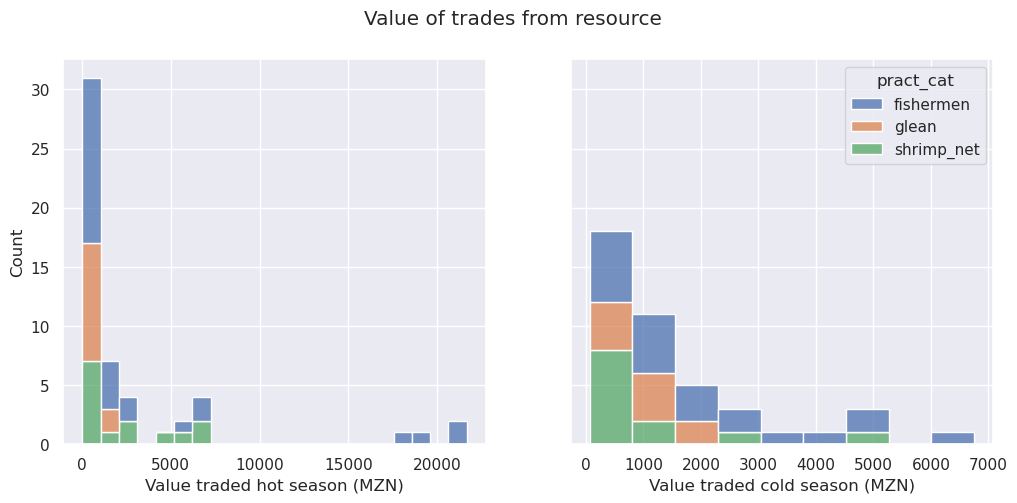

In [2797]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="val_trade_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("Value traded hot season (MZN)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="val_trade_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("Value traded cold season (MZN)")
axes[0].get_legend().remove()
f.suptitle('Value of trades from resource') 
plt.show()

### Income from Intermediary Transactions 
Examine the income respondents made as "guevas" (or resellers of fishing resources) at a resource level

In [2798]:
print("print monthly income from reselling resource - hot season \n" + str(df_wk['resell_hot'].describe()))

print monthly income from reselling resource - hot season 
count      16.000000
mean     1071.875000
std      1718.911356
min         0.000000
25%         0.000000
50%       350.000000
75%       850.000000
max      5000.000000
Name: resell_hot, dtype: float64


In [2799]:
print("resources resold during hot season: \n" + str(df_wk[df_wk['resell_hot']>0]['focal_resource'].unique()))

resources resold during hot season: 
['56' '01' '53' '50' '37']


In [2800]:
print("print monthly income from reselling resource - cold season \n" + str(df_wk['resell_cold'].describe()))

print monthly income from reselling resource - cold season 
count      16.000000
mean     1121.875000
std      1360.265752
min         0.000000
25%         0.000000
50%       800.000000
75%      1650.000000
max      4000.000000
Name: resell_cold, dtype: float64


In [2801]:
print("resources resold during cold season: \n" + str(df_wk[df_wk['resell_cold']>0]['focal_resource'].unique()))

resources resold during cold season: 
['56' '01' '50' '03' '02' '63' '37']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


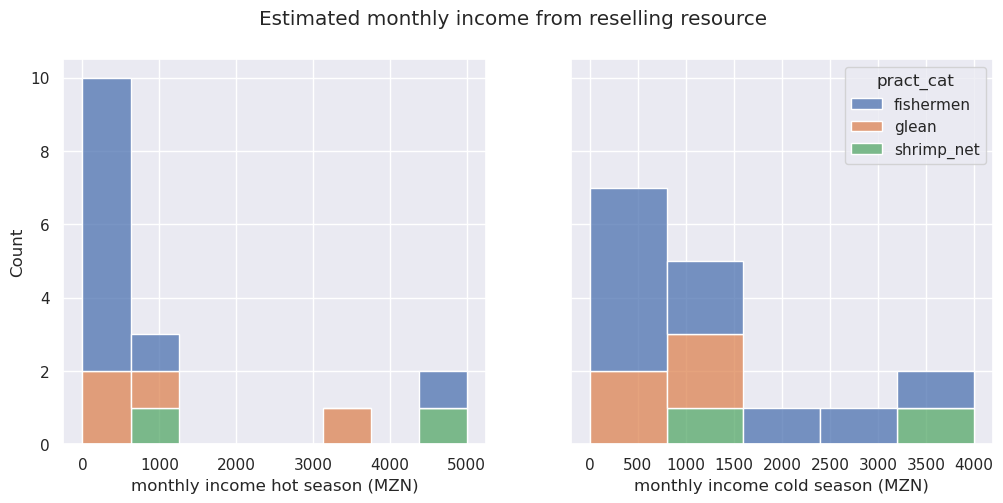

In [2802]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="resell_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("monthly income hot season (MZN)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="resell_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("monthly income cold season (MZN)")
axes[0].get_legend().remove()
f.suptitle('Estimated monthly income from reselling resource') 
plt.show()

There are not many respondents who resell resources. This reflects that most fishers in the sample size dedicate themselves more heavily to fishing. Do to the small sample size, it is difficult to draw many conclusions based on the data. Of the respondents who resell, the majority of them are fishers and shrimpers. They resell crabs, prawns, "mihili", "mavbionho", and "salani"

## Objective 3: Calculate Indicators (Proportion of Income)

The proportion of income from a resource in the repeate table will be calculates as follows: <br>
`(monthly income from resource) / [ (total monthly income from all focal resources) + (total monthly income from other activities) ]` <br>
where <br>
`(monthly income from resource) = (monthly income from sale) + (monthly exchange value of trades) + (monthly income from intermediary transactions)`

Load in the data on income from other activities in the activity repeat table. Sum income at the activity level by responent for each season to get their total non-fishing income.

In [2803]:
# Calculate proportion of income 

# read in the income resource table, which records other income outside of fishing at the activity level for each respondent
inc_raw = os.path.join(sur_B_raw, "other_income_table_3.csv")
df_inc_raw = pd.read_csv(inc_raw)

# agreegate the activity income at the respondent level to sum up the total non-fishing income per respondent during the hot and cold season
df_inc = df_inc_raw.groupby(['ParentGlobalID']).agg({'activity_income_hot': 'sum','activity_income_cold': 'sum'}).reset_index() 

df_inc

,ParentGlobalID,activity_income_hot,activity_income_cold
0,0452b1c9-a249-4667-bf24-bb6969858009,0,1500
1,0d25df79-dc4d-42aa-9bc9-3b705d683d68,38000,38000
2,217d4e9d-94cc-407a-9aaf-9dabfa977971,2000,0
3,21b02f45-d7ae-4f05-9a52-89dad34349af,750,750
4,275be6f1-5e39-4787-a0f6-e532bee2ef83,0,1250
5,2dd5e1ed-eeed-47b2-827d-a0705fc23c7a,0,300
6,310a5eff-b95e-4979-a0dd-c98a7703f436,6000,6000
7,339c9818-8caa-4798-9a51-85ba26bc71c3,5000,5000
8,3f3b6da1-f4ee-467b-9647-aefe9851351f,0,280
9,412ebe42-d0ab-49cd-a390-790fb5dd06a9,16500,16500


Sum the income from the sale of captured reesources, the exchange value of traded resources, and the income from reselling by Parent ID to get the totals for each respondent. Merge the fishing income total table and non-fishing income total table with the capture table.

In [2804]:
# aggregate the capture level data at the respondent level to sum up the total income from fishing during the hot and cold seasons 
# and the total equivalent value of traded products during the hot and cold season
df_wk_inc = df_wk.groupby(['ParentGlobalID']).agg(tot_cap_income_hot=('cap_income_hot', np.sum), est_tot_cap_income_hot=('est_cap_income_hot', np.sum),
                                                tot_val_trade_hot = ('val_trade_hot', np.sum), est_tot_val_trade_hot = ('est_val_trade_hot', np.sum), 
                                                tot_resell_income_hot = ('resell_hot', np.sum), 
                                                tot_cap_income_cold = ('cap_income_cold', np.sum), est_tot_cap_income_cold = ('est_cap_income_cold', np.sum), 
                                                tot_val_trade_cold = ('val_trade_cold', np.sum), est_tot_val_trade_cold = ('est_val_trade_cold', np.sum),
                                                tot_resell_income_cold = ('resell_cold', np.sum)
                                                ).reset_index() 

print("length before merge = "+ str(len(df_wk_inc)))

length before merge = 95


In [2805]:
# merge the non-fishing activity income table with the capture table
df_wk_inc = pd.merge(df_wk_inc,df_inc,on=['ParentGlobalID'], how='left')
print("length after merge = "+ str(len(df_wk_inc)))


length after merge = 95


In [2806]:
# merge the total fishing-income table with the capture table
df_wk = pd.merge(df_wk,df_wk_inc,on=['ParentGlobalID'], how='left')
print("length after merge = "+ str(len(df_wk)))

length after merge = 280


In [2807]:
df_wk_dup = df_wk[df_wk.duplicated(subset=['id','focal_resource'], keep=False)]
df_wk_dup

,ParentGlobalID,id,ccp,gender,fish_pract,owner,catch_proportion,GlobalID,focal_resource,prop_cap_hot_raw,prop_cap_hot,days_hot,quant_cap_hot,cap_units_hot_label,cap_units_hot,cap_units_hot_other,sold_hot_raw,sold_hot,eaten_hot_raw,eaten_hot,traded_hot_raw,traded_hot,offered_hot_raw,offered_hot,sum_use_hot,sale_price_hot,sale_unit_hot,sale_unit_hot_other,prop_cap_cold_raw,prop_cap_cold,gear_used_cold,days_cold,quant_cap_cold,cap_units_cold,cap_units_cold_label,cap_units_cold_other,sold_cold_raw,sold_cold,eaten_cold_raw,eaten_cold,traded_cold_raw,traded_cold,offered_cold_raw,offered_cold,sum_use_cold,sale_price_cold,sale_unit_cold,sale_unit_cold_other,quant_traded,unit_traded,product_recieved,quant_recieved,unit_recieved,value_product_recieved,trade_season,unit_traded_other,unit_recieved_other,resell_hot,resell_cold,product_other,gitonga_s,gitonga_p,portuguese,scientific,family,phylum,category,focal,communities,seagrass,pract_cat,practice_total_beans_hot,practice_total_beans_cold,adj_prop_cap_hot,adj_prop_cap_cold,max_days_hot,max_days_cold,cap_daily_hot,cap_daily_cold,av_cap_daily,est_cap_daily_hot,est_cap_daily_cold,cap_monthly_hot,cap_monthly_cold,est_cap_monthly_hot,est_cap_monthly_cold,cap_income_hot,cap_income_cold,est_cap_income_hot,est_cap_income_cold,estimated_mo_cap_val_hot,estimated_mo_cap_val_cold,val_trade_hot,val_trade_cold,est_val_trade_hot,est_val_trade_cold,tot_cap_income_hot,est_tot_cap_income_hot,tot_val_trade_hot,est_tot_val_trade_hot,tot_resell_income_hot,tot_cap_income_cold,est_tot_cap_income_cold,tot_val_trade_cold,est_tot_val_trade_cold,tot_resell_income_cold,activity_income_hot,activity_income_cold


Any `NaN` values need to be replaced with 0 (no income)

In [2808]:
# list of columns where NaN values should be 0s for computations 
fill_0s = ['activity_income_hot',
            'activity_income_cold',
            'tot_cap_income_hot', 'est_tot_cap_income_hot',
            'tot_cap_income_cold', 'est_tot_cap_income_cold',
            'cap_income_hot', 'est_cap_income_hot',
            'cap_income_cold', 'est_cap_income_cold', 
            'tot_val_trade_hot', 'est_tot_val_trade_hot',
            'val_trade_hot', 'est_val_trade_hot', 
            'val_trade_cold', 'est_val_trade_cold', 
            'tot_val_trade_cold', 'est_tot_val_trade_cold', 
            'tot_resell_income_hot', 
            'tot_resell_income_cold' , 
            'resell_hot', 
            'resell_cold']

# fill NaNs with zeros 
for col in fill_0s:
    df_wk[col].fillna(0, inplace=True)

In [2809]:
# fucntion to calculate proportion of income from a resource
def total_income_resource(income, trade_val, resell):
    total_income_resource = income+ trade_val+ resell
    return total_income_resource

df_wk['income_resource_hot'] = df_wk.apply(lambda row: total_income_resource(row['cap_income_hot'],row['val_trade_hot'], row['resell_hot']), axis=1)
df_wk['income_resource_cold'] = df_wk.apply(lambda row: total_income_resource(row['cap_income_cold'],row['val_trade_cold'], row['resell_cold']), axis=1)
df_wk['est_income_resource_hot'] = df_wk.apply(lambda row: total_income_resource(row['est_cap_income_hot'],row['est_val_trade_hot'], row['resell_hot']), axis=1)
df_wk['est_income_resource_cold'] = df_wk.apply(lambda row: total_income_resource(row['est_cap_income_cold'],row['est_val_trade_cold'], row['resell_cold']), axis=1)

def total_income_respondent( income_tot_fish, trade_tot, other_income, resell_tot):
    total_income_respondent = trade_tot + income_tot_fish + other_income + resell_tot
    return total_income_respondent

df_wk['tot_income_hot'] = df_wk.apply(lambda row: total_income_respondent(row['tot_cap_income_hot'], row['tot_val_trade_hot'], row['activity_income_hot'], row['tot_resell_income_hot']), axis=1)
df_wk['tot_income_cold'] = df_wk.apply(lambda row: total_income_respondent(row['tot_cap_income_cold'], row['tot_val_trade_cold'], row['activity_income_cold'], row['tot_resell_income_cold']), axis=1)
df_wk['est_tot_income_hot'] = df_wk.apply(lambda row: total_income_respondent(row['est_tot_cap_income_hot'], row['est_tot_val_trade_hot'], row['activity_income_hot'], row['tot_resell_income_hot']), axis=1)
df_wk['est_tot_income_cold'] = df_wk.apply(lambda row: total_income_respondent(row['est_tot_cap_income_cold'], row['est_tot_val_trade_cold'], row['activity_income_cold'], row['tot_resell_income_cold']), axis=1)

def prop_income(total_income_resource,total_income_respondent):
    if total_income_resource != 0 and total_income_respondent != 0:
        prop = (total_income_resource)/(total_income_respondent)
    else:
        prop = 0
    return prop

df_wk['prop_income_hot'] = df_wk.apply(lambda row: prop_income(row['income_resource_hot'],row['tot_income_hot']), axis=1)
df_wk['prop_income_cold'] = df_wk.apply(lambda row: prop_income(row['income_resource_cold'],row['tot_income_cold']), axis=1)
df_wk['est_prop_income_hot'] = df_wk.apply(lambda row: prop_income(row['est_income_resource_hot'],row['est_tot_income_hot']), axis=1)
df_wk['est_prop_income_cold'] = df_wk.apply(lambda row: prop_income(row['est_income_resource_cold'],row['est_tot_income_cold']), axis=1)


In [2810]:
df_wk['prop_income_hot'].describe()

count    280.000000
mean       0.317540
std        0.327156
min        0.000000
25%        0.029516
50%        0.211096
75%        0.505661
max        1.000000
Name: prop_income_hot, dtype: float64

In [2811]:
df_wk['prop_income_cold'].describe()

count    280.000000
mean       0.292897
std        0.319619
min        0.000000
25%        0.010364
50%        0.188586
75%        0.469603
max        1.000000
Name: prop_income_cold, dtype: float64

In [2812]:
df_wk.groupby(['pract_cat','focal_resource'])['prop_income_cold'].describe()

count      mean       std       min       25%  \
pract_cat  focal_resource                                                  
fishermen  01               35.0  0.216725  0.223972  0.000000  0.024128   
           02               22.0  0.137095  0.150654  0.000000  0.000000   
           03               24.0  0.243909  0.274717  0.000000  0.000000   
           04                2.0  0.200424  0.053275  0.162753  0.181588   
           06               13.0  0.263773  0.299340  0.000000  0.025604   
           07                4.0  0.067995  0.135991  0.000000  0.000000   
           10                4.0  0.474352  0.121391  0.307946  0.430760   
           50               27.0  0.217954  0.309037  0.000000  0.005283   
           52                6.0  0.038000  0.039412  0.000000  0.002439   
           53               10.0  0.345085  0.255555  0.000000  0.138101   
           54                2.0  0.025026  0.002763  0.023072  0.024049   
           55                3.0  0.512915  0.139892  0.382328  0.439098   
           56               15.0  0.271871  0.261521  0.000000  0.099460   
           61                1.0  0.571429       NaN  0.571429  0.571429   
           78                1.0  0.004253       NaN  0.004253  0.004253   
glean      37                1.0  0.021095       NaN  0.021095  0.021095   
           50               19.0  0.577467  0.380255  0.000000  0.264708   
           52                1.0  0.015825       NaN  0.015825  0.015825   
           56                4.0  0.000000  0.000000  0.000000  0.000000   
           60                7.0  0.239437  0.164831  0.000000  0.144056   
           61                6.0  0.344957  0.263252  0.000000  0.141036   
           63                4.0  0.263986  0.491384  0.000000  0.000000   
           64                2.0  0.078125  0.110485  0.000000  0.039062   
           68                6.0  0.399527  0.390535  0.000000  0.060866   
           69                3.0  0.106061  0.183702  0.000000  0.000000   
           70                1.0  0.000000       NaN  0.000000  0.000000   
           71                1.0  0.000000       NaN  0.000000  0.000000   
           74                1.0  0.000000       NaN  0.000000  0.000000   
           78                6.0  0.319809  0.471363  0.000000  0.000000   
shrimp_net 01                1.0  0.000000       NaN  0.000000  0.000000   
           02                2.0  0.000000  0.000000  0.000000  0.000000   
           03                1.0  0.000000       NaN  0.000000  0.000000   
           06                1.0  0.000000       NaN  0.000000  0.000000   
           50               10.0  0.136548  0.114862  0.000000  0.040473   
           52                2.0  0.139869  0.122057  0.053562  0.096715   
           53                1.0  0.168720       NaN  0.168720  0.168720   
           56               29.0  0.730184  0.283366  0.234128  0.473282   
           63                1.0  0.137405       NaN  0.137405  0.137405   
           71                1.0  0.022901       NaN  0.022901  0.022901   

                                50%       75%       max  
pract_cat  focal_resource                                
fishermen  01              0.142857  0.294118  0.769231  
           02              0.116651  0.255922  0.516779  
           03              0.148281  0.399556  1.000000  
           04              0.200424  0.219260  0.238095  
           06              0.161041  0.380952  1.000000  
           07              0.000000  0.067995  0.271981  
           10              0.498638  0.542230  0.592186  
           50              0.110092  0.271251  1.000000  
           52              0.032797  0.071975  0.085050  
           53              0.392450  0.456379  0.774476  
           54              0.025026  0.026003  0.026980  
           55              0.495868  0.578209  0.660550  
           56              0.285915  0.373809  1.000000  
           61              0.571429  0.5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


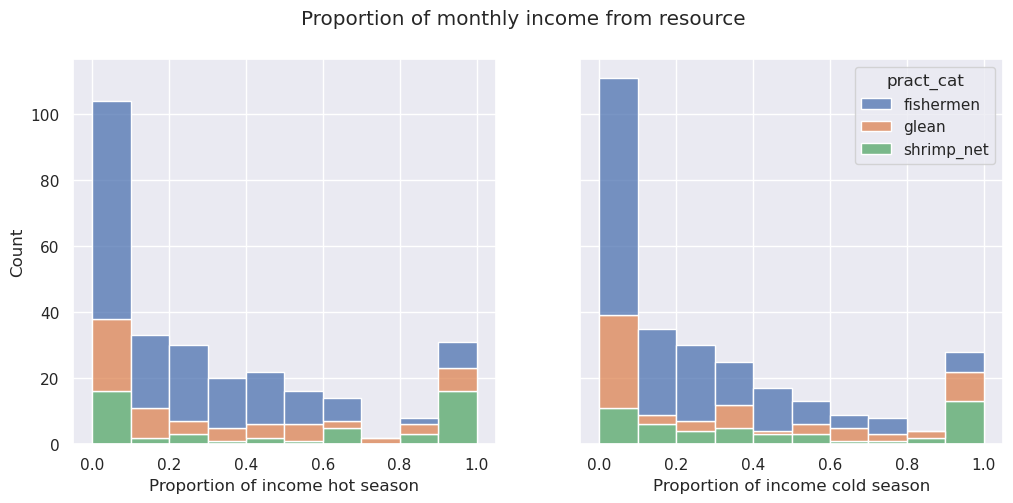

In [2813]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="prop_income_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("Proportion of income hot season")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="prop_income_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("Proportion of income cold season")
axes[0].get_legend().remove()
f.suptitle('Proportion of monthly income from resource') 
plt.show()

In [2814]:

df_wk.groupby(['pract_cat','focal_resource'])['est_prop_income_cold'].describe()

count      mean       std       min       25%  \
pract_cat  focal_resource                                                  
fishermen  01               35.0  0.193644  0.206903  0.000000  0.023903   
           02               22.0  0.110782  0.165298  0.000000  0.000000   
           03               24.0  0.220437  0.274171  0.000000  0.000000   
           04                2.0  0.129867  0.035939  0.104454  0.117160   
           06               13.0  0.272603  0.332549  0.000000  0.017440   
           07                4.0  0.009041  0.018083  0.000000  0.000000   
           10                4.0  0.300256  0.238300  0.097982  0.165355   
           50               27.0  0.193255  0.320441  0.000000  0.003546   
           52                6.0  0.024845  0.024104  0.000000  0.004683   
           53               10.0  0.432919  0.247030  0.000000  0.302009   
           54                2.0  0.128448  0.101630  0.056584  0.092516   
           55                3.0  0.417968  0.162114  0.279785  0.328742   
           56               15.0  0.311514  0.281621  0.000000  0.140123   
           61                1.0  0.390244       NaN  0.390244  0.390244   
           78                1.0  0.015760       NaN  0.015760  0.015760   
glean      37                1.0  0.035228       NaN  0.035228  0.035228   
           50               19.0  0.535081  0.403506  0.000000  0.168946   
           52                1.0  0.035246       NaN  0.035246  0.035246   
           56                4.0  0.000000  0.000000  0.000000  0.000000   
           60                7.0  0.280665  0.209945  0.000000  0.114347   
           61                6.0  0.310510  0.246567  0.000000  0.167515   
           63                4.0  0.315574  0.472741  0.000000  0.000000   
           64                2.0  0.041166  0.058218  0.000000  0.020583   
           68                6.0  0.469094  0.386171  0.000000  0.141504   
           69                3.0  0.174597  0.302410  0.000000  0.000000   
           70                1.0  0.000000       NaN  0.000000  0.000000   
           71                1.0  0.000000       NaN  0.000000  0.000000   
           74                1.0  0.000000       NaN  0.000000  0.000000   
           78                6.0  0.343564  0.502154  0.000000  0.000000   
shrimp_net 01                1.0  0.000000       NaN  0.000000  0.000000   
           02                2.0  0.000000  0.000000  0.000000  0.000000   
           03                1.0  0.000000       NaN  0.000000  0.000000   
           06                1.0  0.000000       NaN  0.000000  0.000000   
           50               10.0  0.095635  0.107690  0.000000  0.037135   
           52                2.0  0.119640  0.099406  0.049349  0.084495   
           53                1.0  0.051817       NaN  0.051817  0.051817   
           56               29.0  0.765002  0.279376  0.180111  0.528768   
           63                1.0  0.101340       NaN  0.101340  0.101340   
           71                1.0  0.033780       NaN  0.033780  0.033780   

                                50%       75%       max  
pract_cat  focal_resource                                
fishermen  01              0.107251  0.320972  0.748352  
           02              0.046079  0.144706  0.705882  
           03              0.143456  0.337759  1.000000  
           04              0.129867  0.142573  0.155280  
           06              0.125094  0.496894  1.000000  
           07              0.000000  0.009041  0.036165  
           10              0.231008  0.365909  0.641026  
           50              0.044677  0.163194  1.000000  
           52              0.021625  0.041782  0.058281  
           53              0.467252  0.599151  0.824982  
           54              0.128448  0.164379  0.200311  
           55              0.377698  0.487060  0.596421  
           56              0.215637  0.431348  1.000000  
           61              0.390244  0.3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


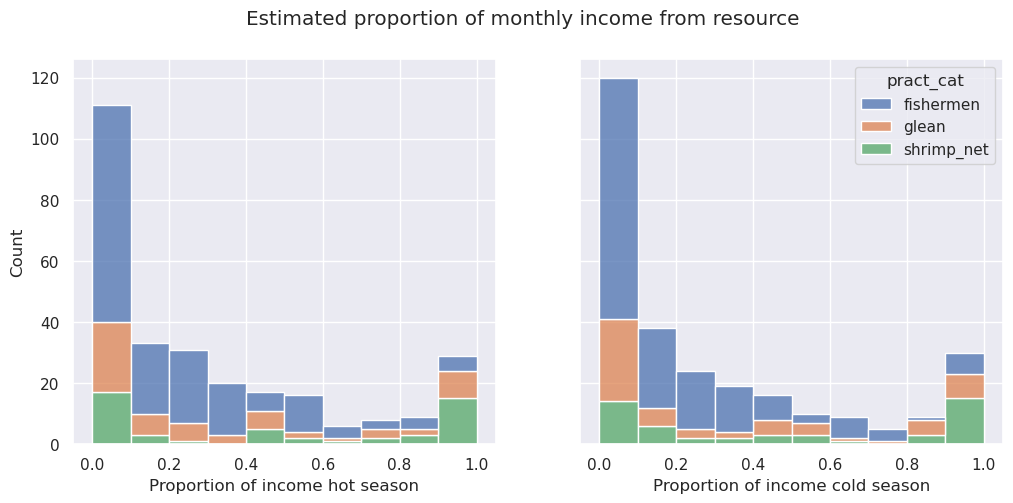

In [2815]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="est_prop_income_hot", kde=False, hue="pract_cat", element="bars",legend=True, ax =axes[0])
axes[0].set_xlabel("Proportion of income hot season")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.histplot(data=df_wk, stat="count",multiple="stack", x="est_prop_income_cold", kde=False, hue="pract_cat", element="bars",legend=True,ax =axes[1])
axes[1].set_xlabel("Proportion of income cold season")
axes[0].get_legend().remove()
f.suptitle('Estimated proportion of monthly income from resource') 
plt.show()

In [2816]:

df_final=df_wk[['focal_resource', 'gitonga_s','gitonga_p', 'portuguese', 
                'scientific', 'family', 'phylum', 'category','focal', 
                'prop_cap_hot', 'prop_cap_cold', 
                'days_hot', 'days_cold', 'cap_daily_hot','cap_daily_cold', 
                'cap_monthly_hot', 'cap_monthly_cold','cap_income_hot', 'cap_income_cold', 
                'val_trade_hot', 'val_trade_cold', 'activity_income_hot', 'activity_income_cold', 
                'income_resource_hot','income_resource_cold', 'tot_income_hot', 'tot_income_cold', 
                'prop_income_hot','est_prop_income_hot', 
                'prop_income_cold', 'est_prop_income_cold','id', 'ccp', 'gender', 
                'fish_pract', 'pract_cat','seagrass']]
df_final.to_csv('../capture_table_clean.csv')

In [2817]:
df_final=df_wk[['focal_resource', 'gitonga_s','gitonga_p', 'portuguese', 
                'scientific', 'family', 'phylum', 'category',
                'cap_income_hot', 'cap_income_cold', 
                'prop_income_hot','prop_income_cold',
                'est_prop_income_hot','est_prop_income_cold','id', 'ccp', 'gender', 
                'fish_pract', 'pract_cat']]
df_final.to_csv('../income_table_clean.csv')

In [2818]:
df_final=df_wk[['focal_resource', 'gitonga_s','gitonga_p', 'portuguese', 
                'scientific', 'family', 'phylum', 'category',
                'prop_cap_hot', 'prop_cap_cold', 
                'cap_monthly_hot', 'cap_monthly_cold',  
                'id', 'ccp', 'gender', 
                'fish_pract', 'pract_cat']]
df_final.to_csv('../captured_table_clean.csv')